Dataset 1 shape: (76, 2)
Dataset 1 labels: [-1.  1.]
Dataset 2 shape: (60, 2)
Dataset 2 labels: [-1.  1.]

--- Part (a): Quadratic Kernel ---
Training on dataset 1 with quadratic kernel...
Number of updates: 86
Number of support vectors: 44
Training on dataset 2 with quadratic kernel...
Number of updates: 1925
Number of support vectors: 45


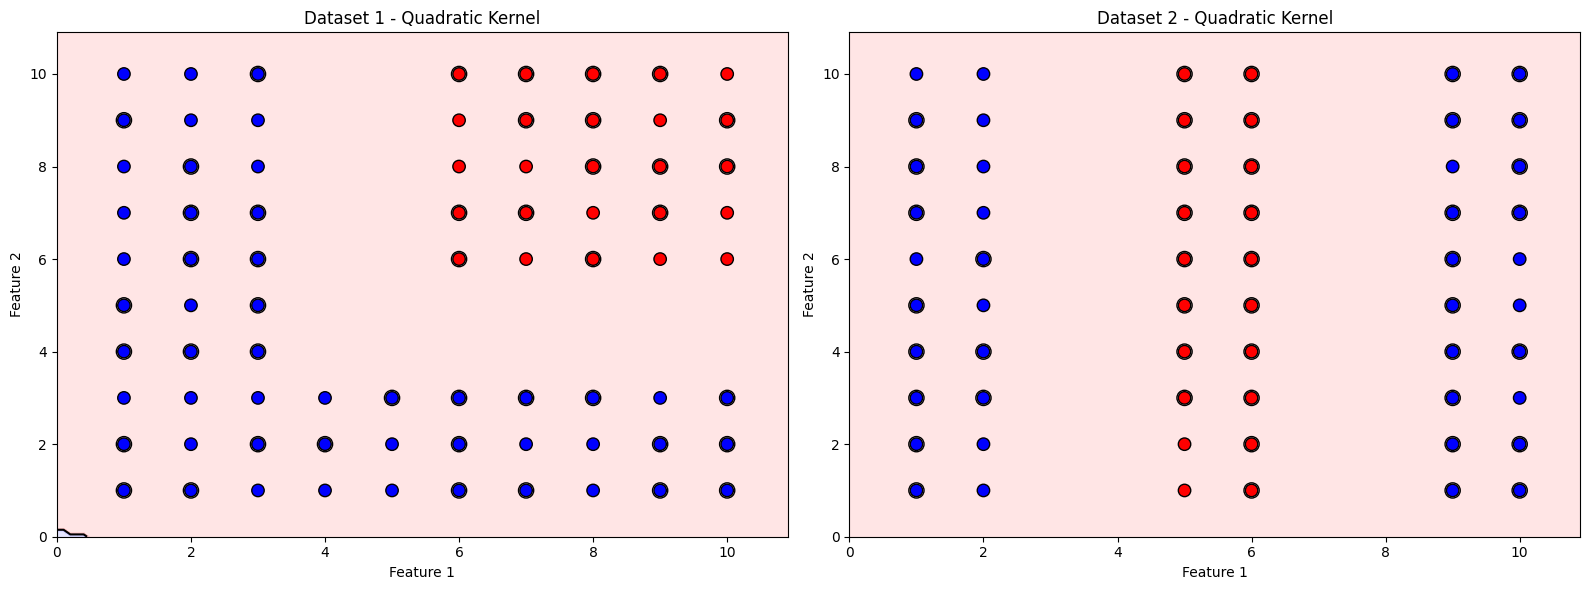


--- Part (b): RBF Kernel ---
Training on dataset 1 with RBF kernel (sigma=1.0)...
Number of updates: 6
Number of support vectors: 6
Training on dataset 2 with RBF kernel (sigma=1.0)...
Number of updates: 8
Number of support vectors: 8
Training on dataset 1 with RBF kernel (sigma=0.1)...
Number of updates: 10
Number of support vectors: 9
Training on dataset 2 with RBF kernel (sigma=0.1)...
Number of updates: 14
Number of support vectors: 12


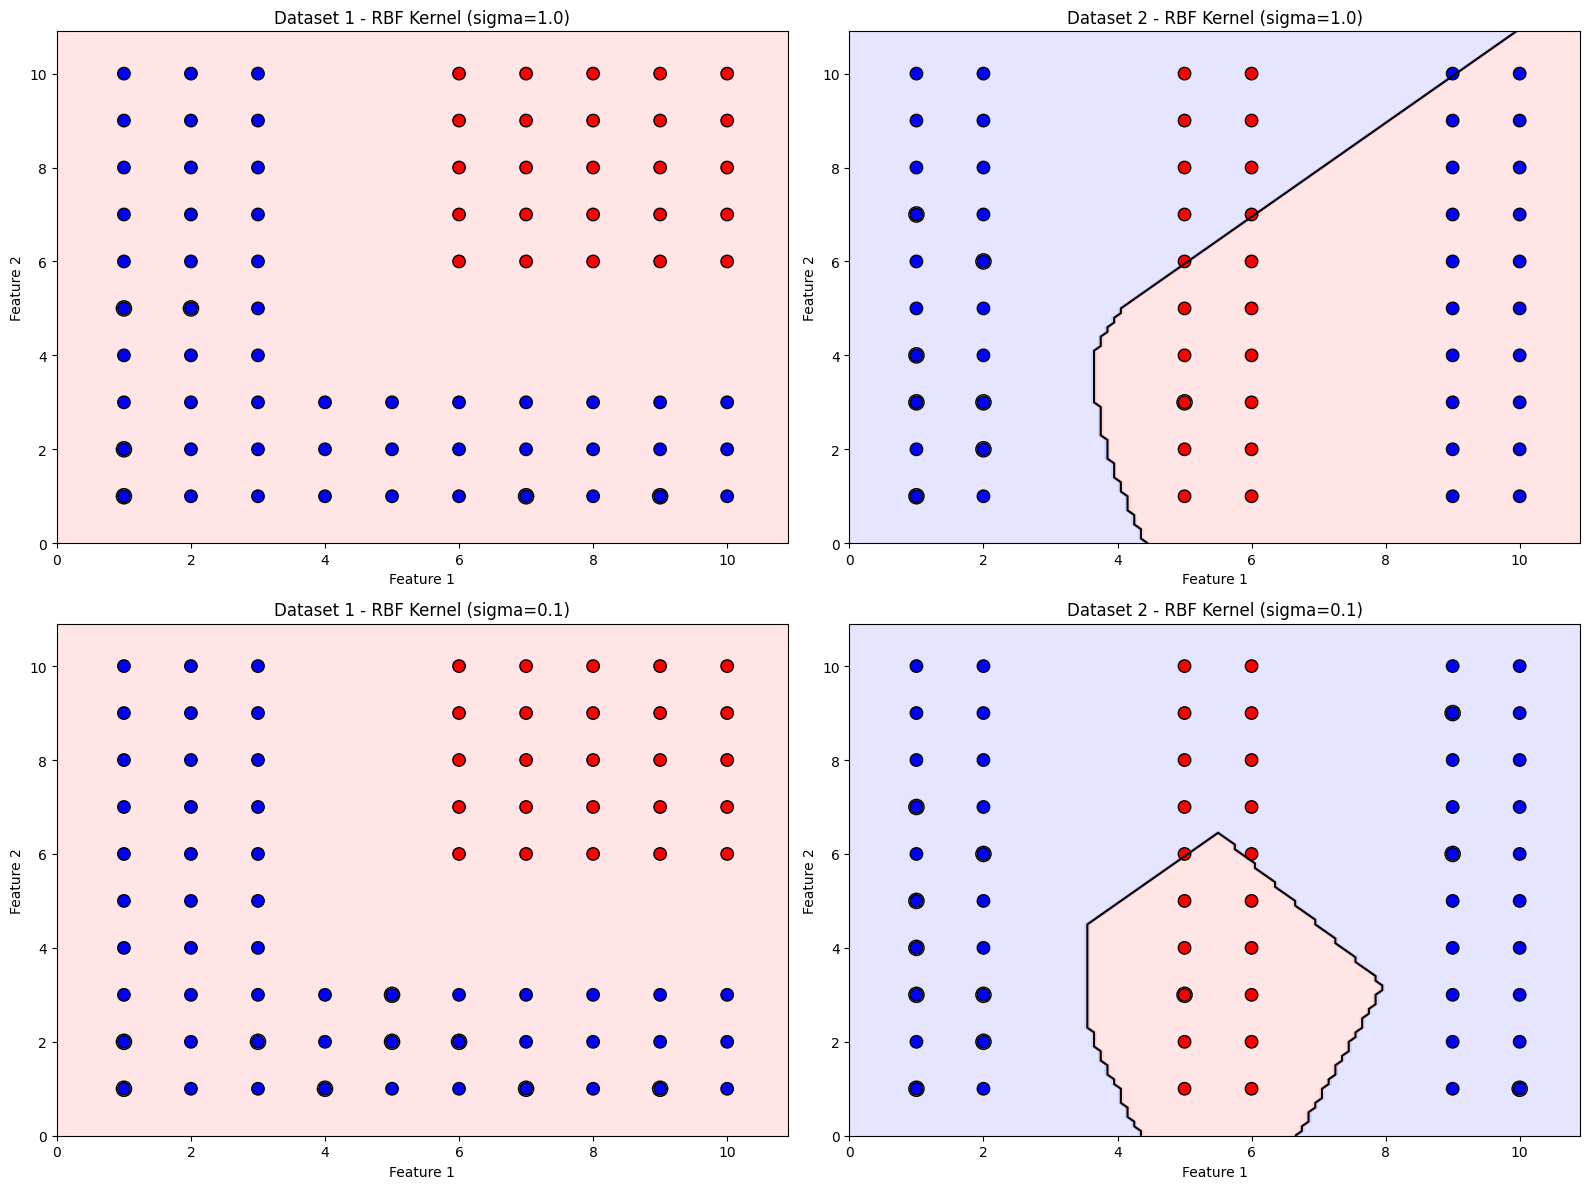

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from matplotlib.colors import ListedColormap

## Load data from data1.txt and data2.txt
data1 = np.loadtxt('data1.txt')
data2 = np.loadtxt('data2.txt')

# Initialize x1, y1 from data1.txt
x1 = data1[:, :2]
y1 = data1[:, 2]

# Initialize x2, y2 from data2.txt
x2 = data2[:, :2]
y2 = data2[:, 2]

## Define quadratic kernel function
def quadratic_kernel(x, z, c=1.0):
    """
    Quadratic kernel: K(x, z) = (x·z + c)²
    
    Args:
        x: First data point (shape: (n_features,))
        z: Second data point (shape: (n_features,))
        c: Constant term added before squaring
        
    Returns:
        Kernel value
    """
    return (np.dot(x, z) + c)**2

## Define RBF kernel function
def rbf_kernel(x, z, c=1.0):
    """
    RBF kernel: K(x, z) = exp(-||x-z||²/(2*c²))
    
    Args:
        x: First data point (shape: (n_features,))
        z: Second data point (shape: (n_features,))
        c: Width parameter of the RBF kernel (sigma)
        
    Returns:
        Kernel value
    """
    return np.exp(-np.linalg.norm(x - z)**2 / (2 * c**2))

def train(x, y, kernel_function, c=1.0, track_updates=True, set_seed=True, max_iter=100):
    """
    Train a kernel perceptron.
    
    Args:
        x: Training data of shape (n_samples, n_features)
        y: Training labels of shape (n_samples,)
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        track_updates: Whether to track and return the number of updates
        set_seed: Whether to set a random seed for shuffling
        max_iter: Maximum number of iterations
        
    Returns:
        alpha: Weight vector
        b: Bias term
        updates: Number of updates (if track_updates=True)
    """
    if set_seed:
        x, y = shuffle(x, y, random_state=42)
    
    n_samples = len(x)
    alpha = np.zeros(n_samples)
    b = 0
    updates = 0
    
    # Precompute kernel matrix for efficiency
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel_function(x[i], x[j], c)
    
    # Training loop
    for _ in range(max_iter):
        mistakes = False
        
        for i in range(n_samples):
            # Compute decision function
            f_xi = 0
            for j in range(n_samples):
                f_xi += alpha[j] * y[j] * K[i, j]
            f_xi += b
            
            # Update if misclassified
            if y[i] * f_xi <= 0:
                alpha[i] += 1
                b += y[i]
                updates += 1
                mistakes = True
        
        # If no mistakes were made, we're done
        if not mistakes:
            break
    
    # Count support vectors
    support_vectors = np.sum(alpha > 0)
    print(f"Number of updates: {updates}")
    print(f"Number of support vectors: {support_vectors}")
    
    if track_updates:
        return alpha, b, updates
    else:
        return alpha, b

def classify(x, y, alpha, b, xi, kernel_function, c=1.0):
    """
    Classify a new data point using the kernel perceptron.
    
    Args:
        x: Training data
        y: Training labels
        alpha: Weight vector
        b: Bias term
        xi: New data point to classify
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        
    Returns:
        Predicted label (-1 or 1)
    """
    f_xi = 0
    for i in range(len(x)):
        f_xi += alpha[i] * y[i] * kernel_function(x[i], xi, c)
    f_xi += b
    
    return 1 if f_xi >= 0 else -1

def plot_decision_boundary(x, y, alpha, b, kernel_function, c, ax, title):
    """
    Plot the decision boundary of a kernel perceptron model on a given axis.
    
    Args:
        x: Training data
        y: Training labels
        alpha: Weight vector
        b: Bias term
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        ax: Matplotlib axis to plot on
        title: Plot title
    """
    # Set plot boundaries with padding
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    # Create a mesh grid
    h = 0.1  # Step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict on the mesh grid
    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            xi = np.array([xx[i, j], yy[i, j]])
            Z[i, j] = classify(x, y, alpha, b, xi, kernel_function, c)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    ax.contour(xx, yy, Z, colors='k', linestyles=['-'], levels=[0])
    
    # Plot data points
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), 
               edgecolors='k', s=80)
    
    # Highlight support vectors
    support_vectors = np.where(alpha > 0)[0]
    ax.scatter(x[support_vectors, 0], x[support_vectors, 1], 
              s=120, linewidth=1, facecolors='none', edgecolors='k')
    
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    # Ensure axes are set properly
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    return ax

def main():
    # Print data information
    print("Dataset 1 shape:", x1.shape)
    print("Dataset 1 labels:", np.unique(y1))
    print("Dataset 2 shape:", x2.shape)
    print("Dataset 2 labels:", np.unique(y2))
    
    # Part (a): Quadratic kernel - 1x2 subplot
    print("\n--- Part (a): Quadratic Kernel ---")
    fig_a, axs_a = plt.subplots(1, 2, figsize=(16, 6))
    
    print("Training on dataset 1 with quadratic kernel...")
    alpha1_quad, b1_quad, updates1_quad = train(x1, y1, quadratic_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_quad, b1_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[0], title="Dataset 1 - Quadratic Kernel")
    
    print("Training on dataset 2 with quadratic kernel...")
    alpha2_quad, b2_quad, updates2_quad = train(x2, y2, quadratic_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_quad, b2_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[1], title="Dataset 2 - Quadratic Kernel")
    
    plt.tight_layout()
    plt.savefig("part_a_quadratic_kernel.png", dpi=300)
    plt.show()
    
    # Part (b): RBF kernel - 2x2 subplot
    print("\n--- Part (b): RBF Kernel ---")
    fig_b, axs_b = plt.subplots(2, 2, figsize=(16, 12))
    
    # Sigma = 1.0
    print("Training on dataset 1 with RBF kernel (sigma=1.0)...")
    alpha1_rbf1, b1_rbf1, updates1_rbf1 = train(x1, y1, rbf_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_rbf1, b1_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 0], title="Dataset 1 - RBF Kernel (sigma=1.0)")
    
    print("Training on dataset 2 with RBF kernel (sigma=1.0)...")
    alpha2_rbf1, b2_rbf1, updates2_rbf1 = train(x2, y2, rbf_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_rbf1, b2_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 1], title="Dataset 2 - RBF Kernel (sigma=1.0)")
    
    # Sigma = 0.1
    print("Training on dataset 1 with RBF kernel (sigma=0.1)...")
    alpha1_rbf2, b1_rbf2, updates1_rbf2 = train(x1, y1, rbf_kernel, c=0.1)
    plot_decision_boundary(x1, y1, alpha1_rbf2, b1_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 0], title="Dataset 1 - RBF Kernel (sigma=0.1)")
    
    print("Training on dataset 2 with RBF kernel (sigma=0.1)...")
    alpha2_rbf2, b2_rbf2, updates2_rbf2 = train(x2, y2, rbf_kernel, c=0.1)
    plot_decision_boundary(x2, y2, alpha2_rbf2, b2_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 1], title="Dataset 2 - RBF Kernel (sigma=0.1)")
    
    plt.tight_layout()
    plt.savefig("part_b_rbf_kernel.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    main()


--- Part (a): Quadratic Kernel ---
Training on dataset 1 with quadratic kernel...
Converged after 86 updates
Number of support vectors: 44
Training on dataset 2 with quadratic kernel...
Did not converge after 1000 iterations
Number of support vectors: 43


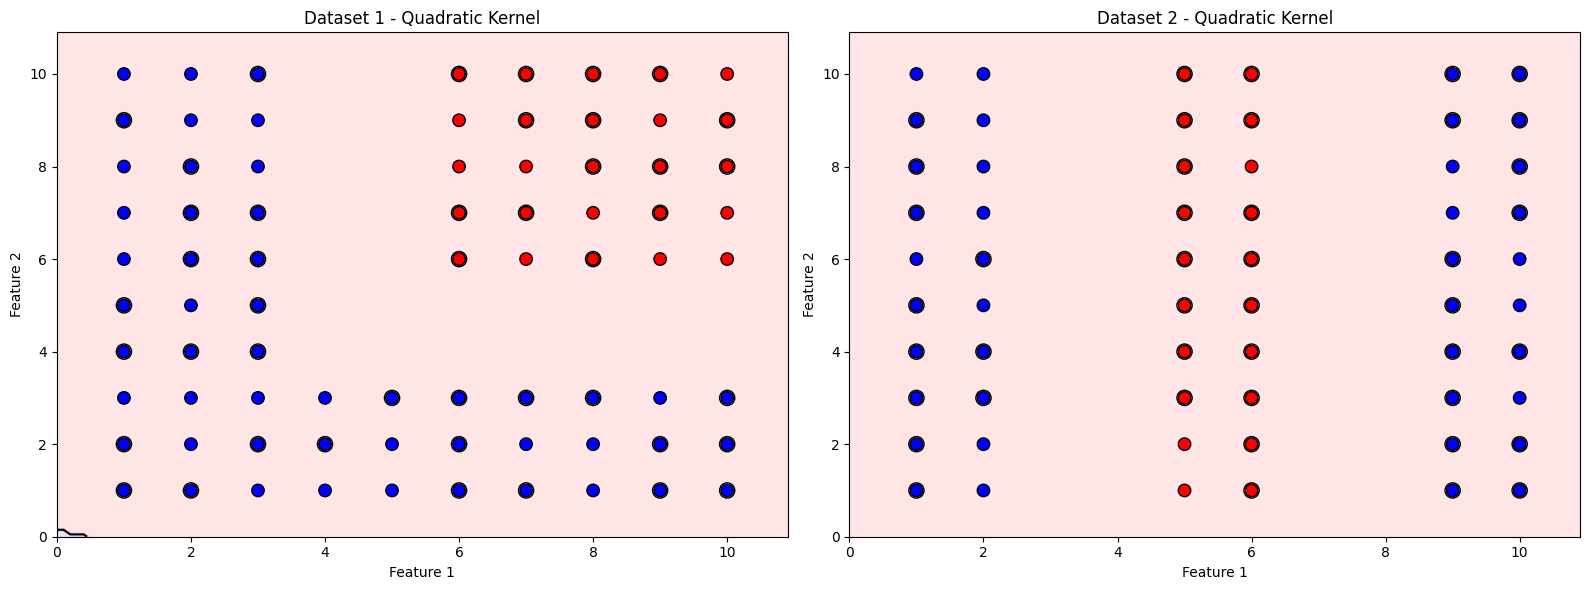


--- Part (b): RBF Kernel ---
Training on dataset 1 with RBF kernel (sigma=1.0)...
Converged after 6 updates
Number of support vectors: 6
Training on dataset 2 with RBF kernel (sigma=1.0)...
Converged after 8 updates
Number of support vectors: 8
Training on dataset 1 with RBF kernel (sigma=0.1)...
Converged after 10 updates
Number of support vectors: 9
Training on dataset 2 with RBF kernel (sigma=0.1)...
Converged after 14 updates
Number of support vectors: 12


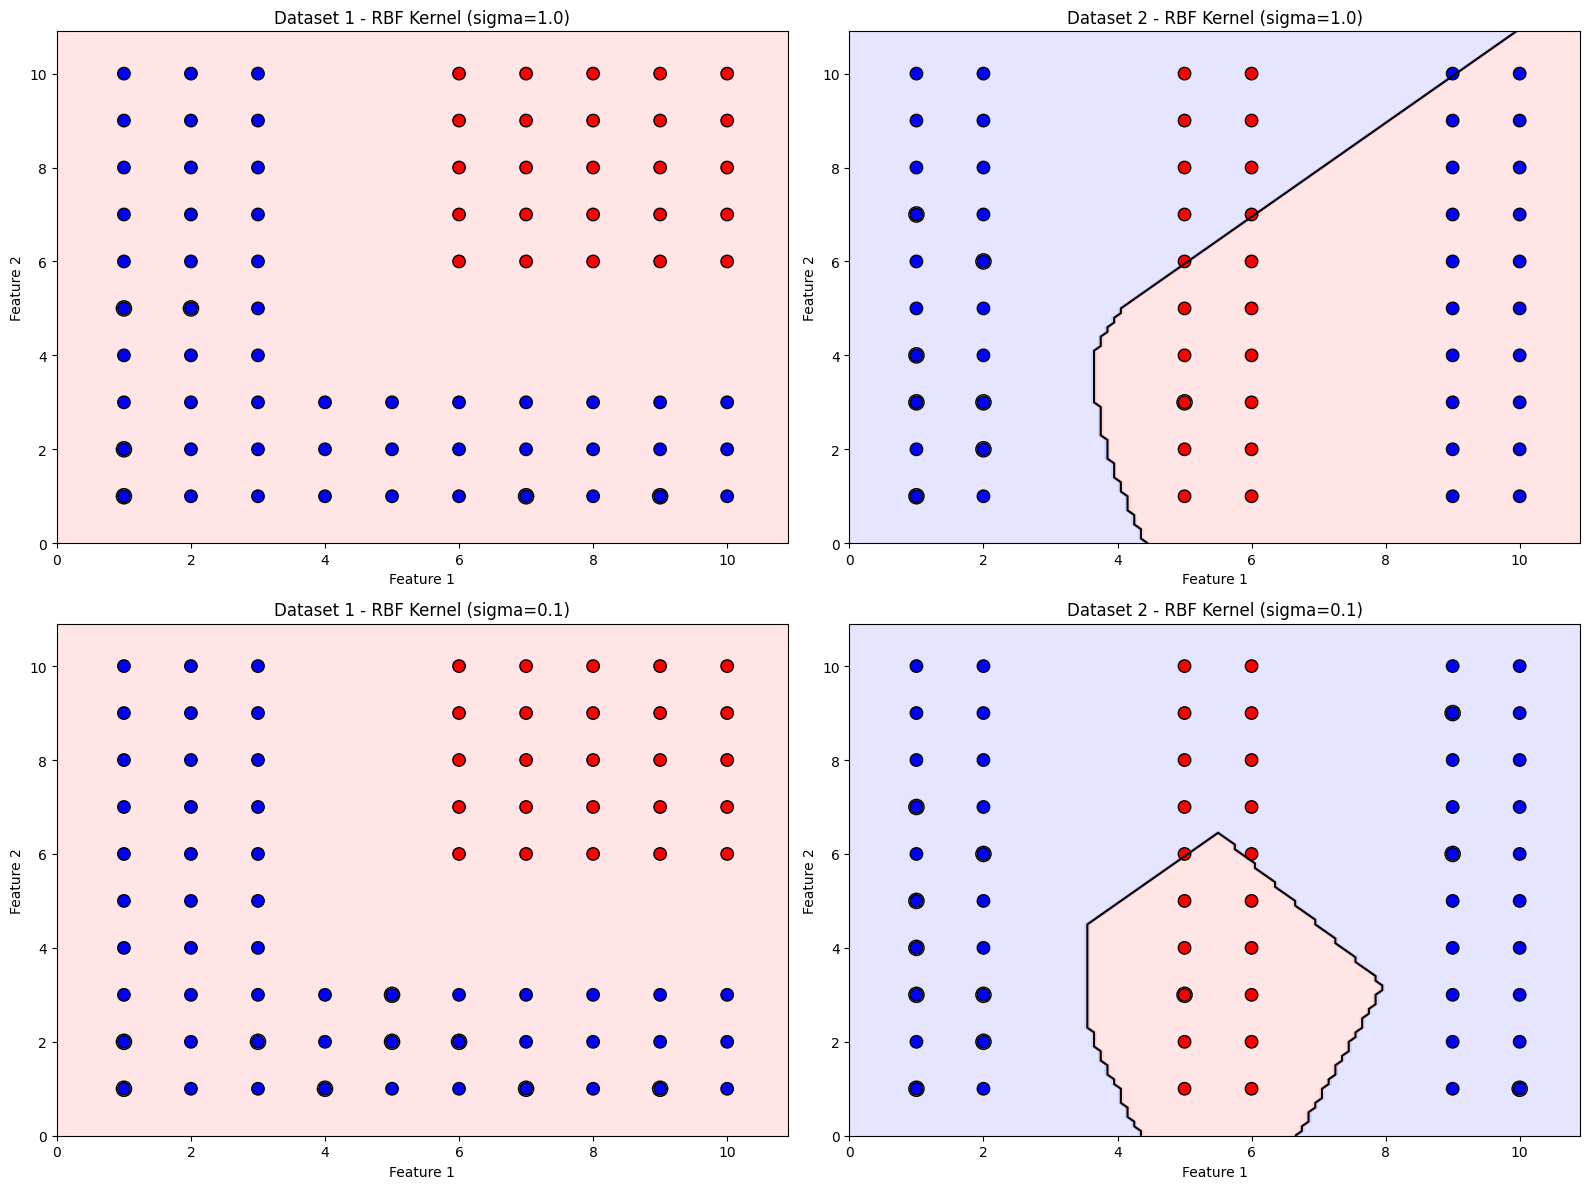

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from matplotlib.colors import ListedColormap

## load data from data1.txt and data2.txt
data1 = np.loadtxt('data1.txt')
data2 = np.loadtxt('data2.txt')

# initialize x1,y1 from data1.txt
x1 = data1[:, :2]
y1 = data1[:, 2]

# initialize x2,y2 from data2.txt
x2 = data2[:, :2]
y2 = data2[:, 2]

## define quadratic kernel function
def quadratic_kernel(x, z, c=1.0):
    ## quadratic kernel function
    return (np.dot(x, z) + c)**2

## define rbf kernel function
def rbf_kernel(x, z, c=1.0):
    ## rbf kernel function
    return np.exp(-np.linalg.norm(x - z)**2 / (2 * c**2))

# this is your train function
def train(x, y, kernel_function, c=1.0, track_updates=True, set_seed=True):
    if set_seed:
        x, y = shuffle(x, y, random_state=42)
    else:
        x, y = shuffle(x, y)
    
    alpha = np.zeros(x.shape[0])
    b = 0
    updates = 0
    max_updates = 1000
    
    # Training loop
    converged = False
    while not converged and updates < max_updates:
        converged = True
        
        for i in range(len(x)):
            # Compute kernel values between current point and all training points
            kernel_vals = np.array([kernel_function(x[j], x[i], c) for j in range(len(x))])
            
            # Compute decision value
            decision = np.sum(alpha * y * kernel_vals) + b
            
            # Update if misclassified
            if y[i] * decision <= 0:
                alpha[i] += 1
                b += y[i]
                updates += 1
                converged = False
    
    if not converged:
        print(f"Did not converge after {max_updates} iterations")
    else:
        print(f"Converged after {updates} updates")
    
    print(f"Number of support vectors: {np.sum(alpha > 0)}")
    
    if track_updates:
        return alpha, b, updates
    else:
        return alpha, b

def classify(x, y, alpha, b, xi, kernel_function, c=1.0):
    ## returns the predicted class
    # Compute kernel values between test point and all training points
    kernel_vals = np.array([kernel_function(x[j], xi, c) for j in range(len(x))])
    
    # Compute decision value
    decision = np.sum(alpha * y * kernel_vals) + b
    
    # Return predicted class
    return 1 if decision >= 0 else -1

def plot_decision_boundary(x, y, alpha, b, kernel_function, c, ax, title):
    """
    Plot the decision boundary of a kernel perceptron model on a given axis.
    
    Args:
        x: Training data
        y: Training labels
        alpha: Weight vector
        b: Bias term
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        ax: Matplotlib axis to plot on
        title: Plot title
    """
    # Set plot boundaries
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    # Create a mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Predict on the mesh grid
    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            xi = np.array([xx[i, j], yy[i, j]])
            Z[i, j] = classify(x, y, alpha, b, xi, kernel_function, c)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    ax.contour(xx, yy, Z, colors='k', linestyles=['-'], levels=[0])
    
    # Plot data points
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), 
               edgecolors='k', s=80)
    
    # Highlight support vectors
    support_vectors = np.where(alpha > 0)[0]
    ax.scatter(x[support_vectors, 0], x[support_vectors, 1], 
              s=120, linewidth=1, facecolors='none', edgecolors='k')
    
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    return ax

def main():
    # Part (a): Quadratic kernel - 1x2 subplot
    print("\n--- Part (a): Quadratic Kernel ---")
    fig_a, axs_a = plt.subplots(1, 2, figsize=(16, 6))
    
    print("Training on dataset 1 with quadratic kernel...")
    alpha1_quad, b1_quad, updates1_quad = train(x1, y1, quadratic_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_quad, b1_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[0], title="Dataset 1 - Quadratic Kernel")
    
    print("Training on dataset 2 with quadratic kernel...")
    alpha2_quad, b2_quad, updates2_quad = train(x2, y2, quadratic_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_quad, b2_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[1], title="Dataset 2 - Quadratic Kernel")
    
    plt.tight_layout()
    plt.savefig("part_a_quadratic_kernel.png", dpi=300)
    plt.show()
    
    # Part (b): RBF kernel - 2x2 subplot
    print("\n--- Part (b): RBF Kernel ---")
    fig_b, axs_b = plt.subplots(2, 2, figsize=(16, 12))
    
    # Sigma = 1.0
    print("Training on dataset 1 with RBF kernel (sigma=1.0)...")
    alpha1_rbf1, b1_rbf1, updates1_rbf1 = train(x1, y1, rbf_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_rbf1, b1_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 0], title="Dataset 1 - RBF Kernel (sigma=1.0)")
    
    print("Training on dataset 2 with RBF kernel (sigma=1.0)...")
    alpha2_rbf1, b2_rbf1, updates2_rbf1 = train(x2, y2, rbf_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_rbf1, b2_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 1], title="Dataset 2 - RBF Kernel (sigma=1.0)")
    
    # Sigma = 0.1
    print("Training on dataset 1 with RBF kernel (sigma=0.1)...")
    alpha1_rbf2, b1_rbf2, updates1_rbf2 = train(x1, y1, rbf_kernel, c=0.1)
    plot_decision_boundary(x1, y1, alpha1_rbf2, b1_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 0], title="Dataset 1 - RBF Kernel (sigma=0.1)")
    
    print("Training on dataset 2 with RBF kernel (sigma=0.1)...")
    alpha2_rbf2, b2_rbf2, updates2_rbf2 = train(x2, y2, rbf_kernel, c=0.1)
    plot_decision_boundary(x2, y2, alpha2_rbf2, b2_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 1], title="Dataset 2 - RBF Kernel (sigma=0.1)")
    
    plt.tight_layout()
    plt.savefig("part_b_rbf_kernel.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

## load data0.txt
data = np.loadtxt('data0.txt', dtype=int)
x = data[:, :2]
y = data[:, 2]

# this is your kernel function
def multi_perceptron(w, b, x):
    predictions = np.dot(w, x) + b
    best_prediction = predictions.argmax()
    return(best_prediction)
    
# this is your train function
def fit_multi_perceptron(x, y, track_updates, set_seed):
    if set_seed:
        x, y = shuffle(x, y,random_state=42)
    else:
        x, y = shuffle(x, y)
    ## alpha vector of zeros that equal dimensions of x (i.e number of samples)
    ## shape of x1 is (76,2)
    alpha = np.zeros(x.shape[0])
    b = 0
    updates = 0
    max_updates = 1000
    # this is your classify
    def make_prediction(w, b, x, y, updates):
        error = False    
        for xi, yi in zip(x, y):
            predicted_y = multi_perceptron(w, b, xi) # this is your kernel function
            if predicted_y != yi:
                alpha[yi] += xi
                b[yi] += 1
                w[predicted_y] -= xi
                b[predicted_y] -= 1
                updates += 1
                error = True  
        if updates <= max_updates:
            if error:
                return make_prediction(w, b, x, y, updates) 
            else:
                return (w, b, updates)
        else:
            print("Did not converge after {max_iterations} iterations")
    if track_updates:
        w, b, updates = make_prediction(w, b, x, y, updates)
        return (w, b, updates)
    else:
        w, b, updates = make_prediction(w, b, x, y, updates)
        return (w, b)

In [26]:
import numpy as np
from sklearn.utils import shuffle
## load data from data1.txt and data2.txt
data1 = np.loadtxt('data1.txt', dtype=int)
data2 = np.loadtxt('data2.txt', dtype=int)

# initalize x1,y1 from data1.txt
x1 = data1[:, :2]
y1 = data1[:, 2]
#for i, (xi, yi) in enumerate(zip(x1, y1)):
#    print(xi,yi)
## define quadradic kernel function
def quadratic_kernel(x, z, c=1.0):
    ## quadratic kernel function
    return (np.dot(x, z) + c)**2

## define rbf kernel fucntion
def rbf_kernel(x,z, c=1.0):
    ## rbf kernel function
    return(np.exp(-np.linalg.norm(x - z)**2 / (2 * c**2)))

qk = quadratic_kernel(x1, x1[0], c=1.0)
print(qk)
k_vec = np.array([quadratic_kernel(xj, x1[0], c=1.0) for xj in x1])
print(k_vec)

[  9.  16.  25.  36.  49.  64.  81. 100. 121. 144.  16.  25.  36.  49.
  64.  81. 100. 121. 144. 169.  25.  36.  49.  64.  81. 100. 121. 144.
 169. 196.  36.  49.  64.  49.  64.  81.  64.  81. 100.  81. 100. 121.
 100. 121. 144. 121. 144. 169. 144. 169. 196. 169. 196. 225. 256. 289.
 196. 225. 256. 289. 324. 225. 256. 289. 324. 361. 256. 289. 324. 361.
 400. 289. 324. 361. 400. 441.]
[  9.  16.  25.  36.  49.  64.  81. 100. 121. 144.  16.  25.  36.  49.
  64.  81. 100. 121. 144. 169.  25.  36.  49.  64.  81. 100. 121. 144.
 169. 196.  36.  49.  64.  49.  64.  81.  64.  81. 100.  81. 100. 121.
 100. 121. 144. 121. 144. 169. 144. 169. 196. 169. 196. 225. 256. 289.
 196. 225. 256. 289. 324. 225. 256. 289. 324. 361. 256. 289. 324. 361.
 400. 289. 324. 361. 400. 441.]


### question 6 a & b


--- Part (a): Quadratic Kernel ---
Training on dataset 1 with quadratic kernel...
Converged!
Number of support vectors: 36
Training on dataset 2 with quadratic kernel...
Number of support vectors: 47


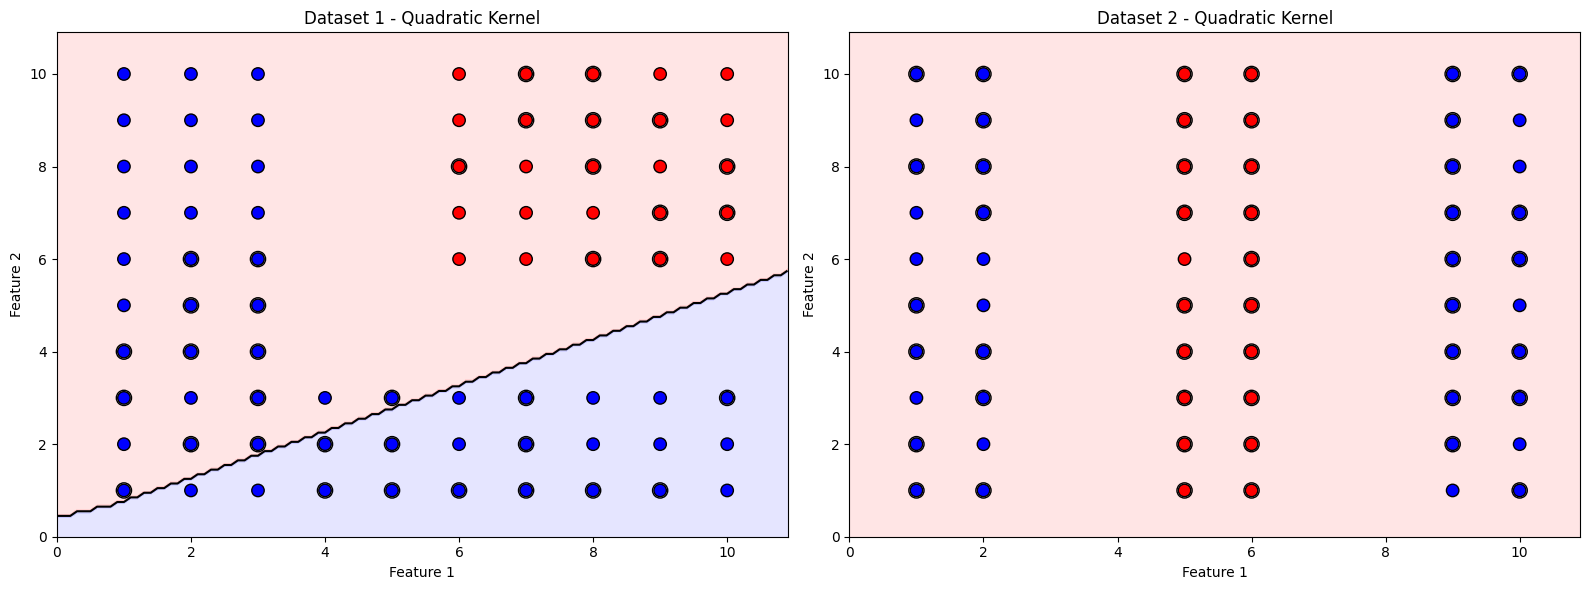


--- Part (b): RBF Kernel ---
Training on dataset 1 with RBF kernel (sigma=1.0)...
Converged!
Number of support vectors: 6
Training on dataset 2 with RBF kernel (sigma=1.0)...
Converged!
Number of support vectors: 12
Training on dataset 1 with RBF kernel (sigma=0.1)...
Converged!
Number of support vectors: 6
Training on dataset 2 with RBF kernel (sigma=0.1)...
Converged!
Number of support vectors: 12


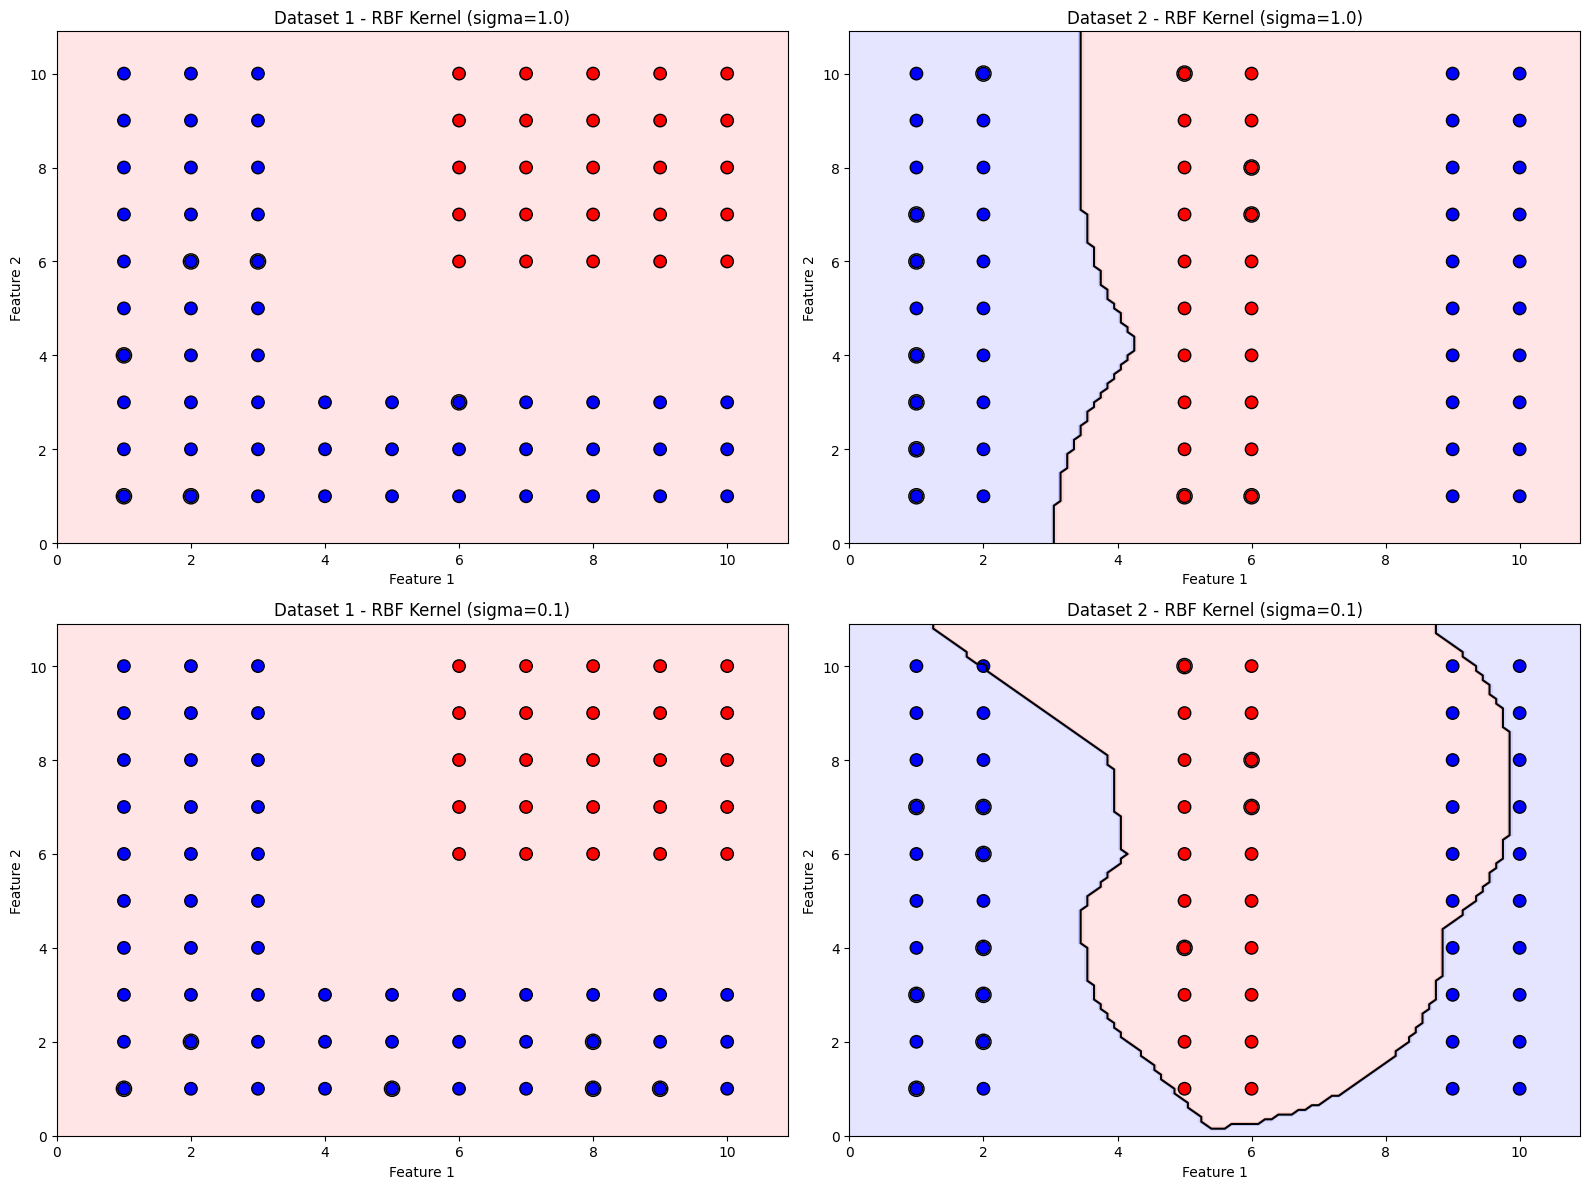

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def quadratic_kernel(x, z, c):
    """
    Quadratic kernel: K(x, z) = (x·z + c)²
    
    Args:
        x: First data point (shape: (n_features,))
        z: Second data point (shape: (n_features,))
        c: Constant term added before squaring
        
    Returns:
        Kernel value
    """
    return (np.dot(x, z) + c)**2

def rbf_kernel(x, z, c):
    """
    RBF kernel: K(x, z) = exp(-||x-z||²/(2*c²))
    
    Args:
        x: First data point (shape: (n_features,))
        z: Second data point (shape: (n_features,))
        c: Width parameter of the RBF kernel (sigma)
        
    Returns:
        Kernel value
    """
    return np.exp(-np.linalg.norm(x-z)**2/(2*c**2))

def train(x, y, kernel_function, c=1.0, max_iter=1000):
    """
    Train a kernel perceptron.
    
    Args:
        x: Training data of shape (n_samples, n_features)
        y: Training labels of shape (n_samples,)
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        max_iter: Maximum number of iterations
        
    Returns:
        alpha: Weight vector
        b: Bias term
    """
    n_samples = len(x)
    alpha = np.zeros(n_samples)
    b = 0
    x, y = shuffle(x, y)
    # Precompute kernel matrix for efficiency
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel_function(x[i], x[j], c)
    
    # Training loop
    for _ in range(max_iter):
        mistakes = False
        
        for i in range(n_samples):
            # Compute prediction
            f_xi = 0
            for j in range(n_samples):
                f_xi += alpha[j] * y[j] * K[i, j]
            f_xi += b
            
            # Update if misclassified
            if y[i] * f_xi <= 0:
                alpha[i] += 1
                b += y[i]
                mistakes = True
        
        # If no mistakes were made, we're done
        if not mistakes:
            print("Converged!")
            break
    
    # Count support vectors
    support_vectors = np.sum(alpha > 0)
    print(f"Number of support vectors: {support_vectors}")
    
    return alpha, b

def classify(x, y, alpha, b, xi, kernel_function, c=1.0):
    """
    Classify a new data point using the kernel perceptron.
    
    Args:
        x: Training data of shape (n_samples, n_features)
        y: Training labels of shape (n_samples,)
        alpha: Weight vector
        b: Bias term
        xi: New data point to classify
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        
    Returns:
        Predicted label (-1 or 1)
    """
    f_xi = 0
    for i in range(len(x)):
        f_xi += alpha[i] * y[i] * kernel_function(x[i], xi, c)
    f_xi += b
    
    return 1 if f_xi >= 0 else -1

def plot_decision_boundary(x, y, alpha, b, kernel_function, c, ax, title):
    """
    Plot the decision boundary of a kernel perceptron model on a given axis.
    
    Args:
        x: Training data
        y: Training labels
        alpha: Weight vector
        b: Bias term
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        ax: Matplotlib axis to plot on
        title: Plot title
    """
    # Set plot boundaries
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    # Create a mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Predict on the mesh grid
    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            xi = np.array([xx[i, j], yy[i, j]])
            Z[i, j] = classify(x, y, alpha, b, xi, kernel_function, c)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    ax.contour(xx, yy, Z, colors='k', linestyles=['-'], levels=[0])
    
    # Plot data points
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), 
               edgecolors='k', s=80)
    
    # Highlight support vectors
    support_vectors = np.where(alpha > 0)[0]
    ax.scatter(x[support_vectors, 0], x[support_vectors, 1], 
              s=120, linewidth=1, facecolors='none', edgecolors='k')
    
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    return ax

def main():
    # Load data
    data1 = np.loadtxt('data1.txt')
    data2 = np.loadtxt('data2.txt')
    
    # Extract features and labels
    x1 = data1[:, :2]
    y1 = data1[:, 2]
    
    x2 = data2[:, :2]
    y2 = data2[:, 2]
    
    # Part (a): Quadratic kernel - 1x2 subplot
    print("\n--- Part (a): Quadratic Kernel ---")
    fig_a, axs_a = plt.subplots(1, 2, figsize=(16, 6))
    
    print("Training on dataset 1 with quadratic kernel...")
    alpha1_quad, b1_quad = train(x1, y1, quadratic_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_quad, b1_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[0], title="Dataset 1 - Quadratic Kernel")
    
    print("Training on dataset 2 with quadratic kernel...")
    alpha2_quad, b2_quad = train(x2, y2, quadratic_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_quad, b2_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[1], title="Dataset 2 - Quadratic Kernel")
    
    plt.tight_layout()
    plt.savefig("part_a_quadratic_kernel.png", dpi=300)
    plt.show()
    
    # Part (b): RBF kernel - 2x2 subplot
    print("\n--- Part (b): RBF Kernel ---")
    fig_b, axs_b = plt.subplots(2, 2, figsize=(16, 12))
    
    # Sigma = 1.0
    print("Training on dataset 1 with RBF kernel (sigma=1.0)...")
    alpha1_rbf1, b1_rbf1 = train(x1, y1, rbf_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_rbf1, b1_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 0], title="Dataset 1 - RBF Kernel (sigma=1.0)")
    
    print("Training on dataset 2 with RBF kernel (sigma=1.0)...")
    alpha2_rbf1, b2_rbf1 = train(x2, y2, rbf_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_rbf1, b2_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 1], title="Dataset 2 - RBF Kernel (sigma=1.0)")
    
    # Sigma = 0.1
    print("Training on dataset 1 with RBF kernel (sigma=0.1)...")
    alpha1_rbf2, b1_rbf2 = train(x1, y1, rbf_kernel, c=0.1)
    plot_decision_boundary(x1, y1, alpha1_rbf2, b1_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 0], title="Dataset 1 - RBF Kernel (sigma=0.1)")
    
    print("Training on dataset 2 with RBF kernel (sigma=0.1)...")
    alpha2_rbf2, b2_rbf2 = train(x2, y2, rbf_kernel, c=0.1)
    plot_decision_boundary(x2, y2, alpha2_rbf2, b2_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 1], title="Dataset 2 - RBF Kernel (sigma=0.1)")
    
    plt.tight_layout()
    plt.savefig("part_b_rbf_kernel.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    main()

Dataset 1 shape: (76, 2)
Dataset 1 labels: [-1.  1.]
Dataset 2 shape: (60, 2)
Dataset 2 labels: [-1.  1.]

--- Part (a): Quadratic Kernel ---
Training on dataset 1 with quadratic kernel...
Number of updates: 86
Number of support vectors: 44
Training on dataset 2 with quadratic kernel...
Number of updates: 1925
Number of support vectors: 45


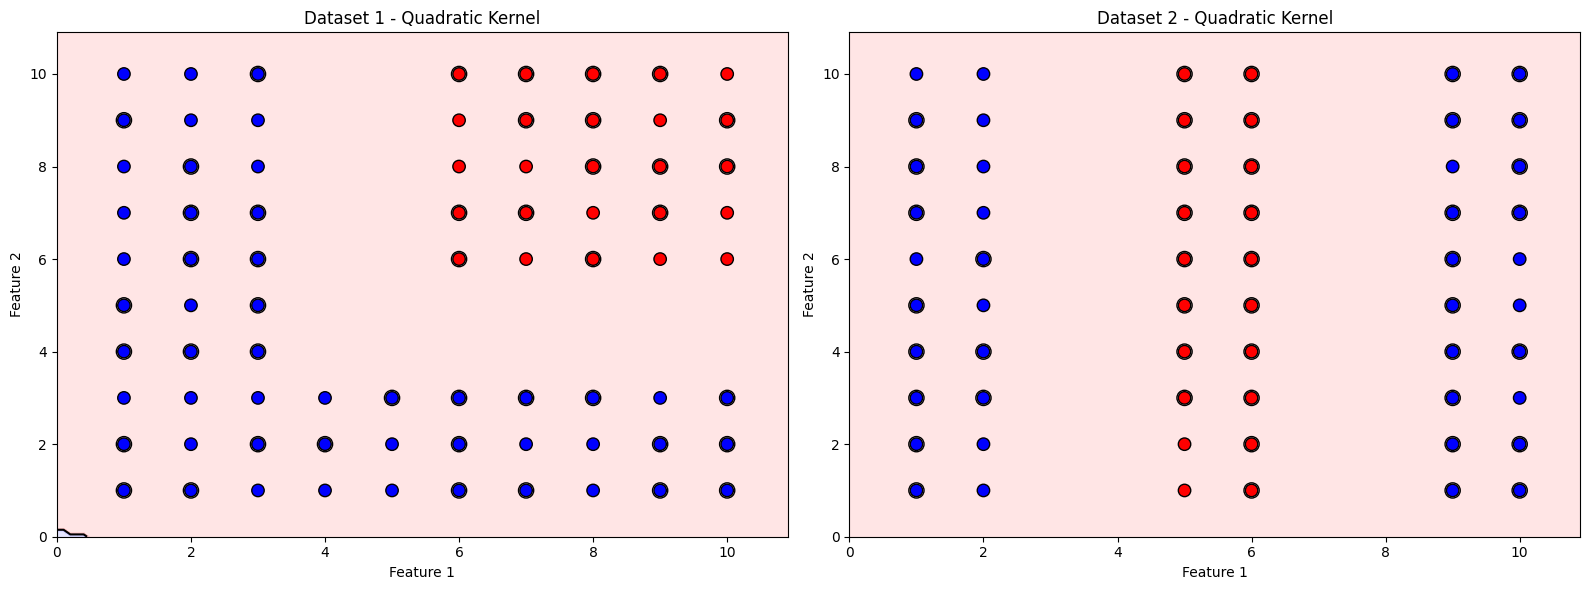


--- Part (b): RBF Kernel ---
Training on dataset 1 with RBF kernel (sigma=1.0)...
Number of updates: 6
Number of support vectors: 6
Training on dataset 2 with RBF kernel (sigma=1.0)...
Number of updates: 8
Number of support vectors: 8
Training on dataset 1 with RBF kernel (sigma=0.1)...
Number of updates: 10
Number of support vectors: 9
Training on dataset 2 with RBF kernel (sigma=0.1)...
Number of updates: 14
Number of support vectors: 12


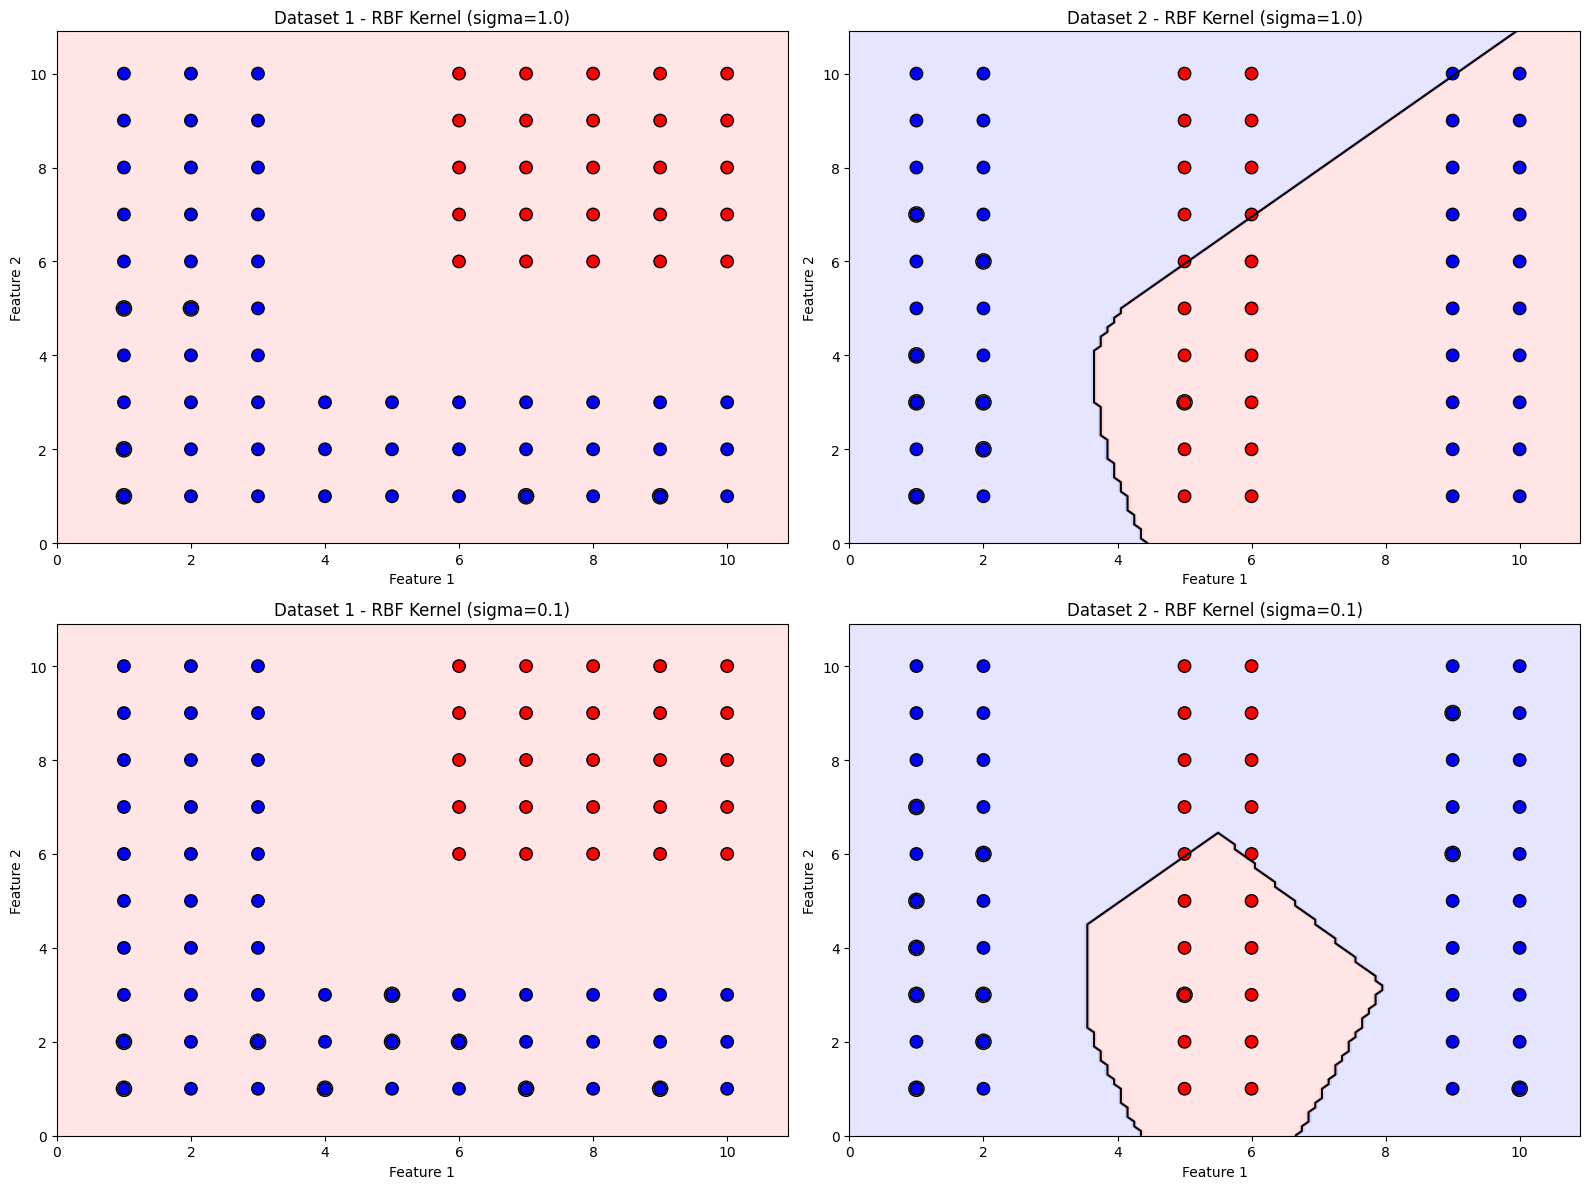

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from matplotlib.colors import ListedColormap

## Load data from data1.txt and data2.txt
data1 = np.loadtxt('data1.txt')
data2 = np.loadtxt('data2.txt')

# Initialize x1, y1 from data1.txt
x1 = data1[:, :2]
y1 = data1[:, 2]

# Initialize x2, y2 from data2.txt
x2 = data2[:, :2]
y2 = data2[:, 2]

## Define quadratic kernel function
def quadratic_kernel(x, z, c=1.0):
    """
    Quadratic kernel: K(x, z) = (x·z + c)²
    
    Args:
        x: First data point (shape: (n_features,))
        z: Second data point (shape: (n_features,))
        c: Constant term added before squaring
        
    Returns:
        Kernel value
    """
    return (np.dot(x, z) + c)**2

## Define RBF kernel function
def rbf_kernel(x, z, c=1.0):
    """
    RBF kernel: K(x, z) = exp(-||x-z||²/(2*c²))
    
    Args:
        x: First data point (shape: (n_features,))
        z: Second data point (shape: (n_features,))
        c: Width parameter of the RBF kernel (sigma)
        
    Returns:
        Kernel value
    """
    return np.exp(-np.linalg.norm(x - z)**2 / (2 * c**2))

def train(x, y, kernel_function, c=1.0, track_updates=True, set_seed=True, max_iter=100):
    """
    Train a kernel perceptron.
    
    Args:
        x: Training data of shape (n_samples, n_features)
        y: Training labels of shape (n_samples,)
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        track_updates: Whether to track and return the number of updates
        set_seed: Whether to set a random seed for shuffling
        max_iter: Maximum number of iterations
        
    Returns:
        alpha: Weight vector
        b: Bias term
        updates: Number of updates (if track_updates=True)
    """
    if set_seed:
        x, y = shuffle(x, y, random_state=42)
    
    n_samples = len(x)
    alpha = np.zeros(n_samples)
    b = 0
    updates = 0
    
    # Precompute kernel matrix for efficiency
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel_function(x[i], x[j], c)
    
    # Training loop
    for _ in range(max_iter):
        mistakes = False
        
        for i in range(n_samples):
            # Compute decision function
            f_xi = 0
            for j in range(n_samples):
                f_xi += alpha[j] * y[j] * K[i, j]
            f_xi += b
            
            # Update if misclassified
            if y[i] * f_xi <= 0:
                alpha[i] += 1
                b += y[i]
                updates += 1
                mistakes = True
        
        # If no mistakes were made, we're done
        if not mistakes:
            break
    
    # Count support vectors
    support_vectors = np.sum(alpha > 0)
    print(f"Number of updates: {updates}")
    print(f"Number of support vectors: {support_vectors}")
    
    if track_updates:
        return alpha, b, updates
    else:
        return alpha, b

def classify(x, y, alpha, b, xi, kernel_function, c=1.0):
    """
    Classify a new data point using the kernel perceptron.
    
    Args:
        x: Training data
        y: Training labels
        alpha: Weight vector
        b: Bias term
        xi: New data point to classify
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        
    Returns:
        Predicted label (-1 or 1)
    """
    f_xi = 0
    for i in range(len(x)):
        f_xi += alpha[i] * y[i] * kernel_function(x[i], xi, c)
    f_xi += b
    
    return 1 if f_xi >= 0 else -1

def plot_decision_boundary(x, y, alpha, b, kernel_function, c, ax, title):
    """
    Plot the decision boundary of a kernel perceptron model on a given axis.
    
    Args:
        x: Training data
        y: Training labels
        alpha: Weight vector
        b: Bias term
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        ax: Matplotlib axis to plot on
        title: Plot title
    """
    # Set plot boundaries with padding
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    # Create a mesh grid
    h = 0.1  # Step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict on the mesh grid
    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            xi = np.array([xx[i, j], yy[i, j]])
            Z[i, j] = classify(x, y, alpha, b, xi, kernel_function, c)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    ax.contour(xx, yy, Z, colors='k', linestyles=['-'], levels=[0])
    
    # Plot data points
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), 
               edgecolors='k', s=80)
    
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    # Ensure axes are set properly
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    return ax

def main():
    # Print data information
    print("Dataset 1 shape:", x1.shape)
    print("Dataset 1 labels:", np.unique(y1))
    print("Dataset 2 shape:", x2.shape)
    print("Dataset 2 labels:", np.unique(y2))
    
    # Part (a): Quadratic kernel - 1x2 subplot
    print("\n--- Part (a): Quadratic Kernel ---")
    fig_a, axs_a = plt.subplots(1, 2, figsize=(16, 6))
    
    print("Training on dataset 1 with quadratic kernel...")
    alpha1_quad, b1_quad, updates1_quad = train(x1, y1, quadratic_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_quad, b1_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[0], title="Dataset 1 - Quadratic Kernel")
    
    print("Training on dataset 2 with quadratic kernel...")
    alpha2_quad, b2_quad, updates2_quad = train(x2, y2, quadratic_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_quad, b2_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[1], title="Dataset 2 - Quadratic Kernel")
    
    plt.tight_layout()
    plt.savefig("part_a_quadratic_kernel.png", dpi=300)
    plt.show()
    
    # Part (b): RBF kernel - 2x2 subplot
    print("\n--- Part (b): RBF Kernel ---")
    fig_b, axs_b = plt.subplots(2, 2, figsize=(16, 12))
    
    # Sigma = 1.0
    print("Training on dataset 1 with RBF kernel (sigma=1.0)...")
    alpha1_rbf1, b1_rbf1, updates1_rbf1 = train(x1, y1, rbf_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_rbf1, b1_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 0], title="Dataset 1 - RBF Kernel (sigma=1.0)")
    
    print("Training on dataset 2 with RBF kernel (sigma=1.0)...")
    alpha2_rbf1, b2_rbf1, updates2_rbf1 = train(x2, y2, rbf_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_rbf1, b2_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 1], title="Dataset 2 - RBF Kernel (sigma=1.0)")
    
    # Sigma = 0.1
    print("Training on dataset 1 with RBF kernel (sigma=0.1)...")
    alpha1_rbf2, b1_rbf2, updates1_rbf2 = train(x1, y1, rbf_kernel, c=0.1)
    plot_decision_boundary(x1, y1, alpha1_rbf2, b1_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 0], title="Dataset 1 - RBF Kernel (sigma=0.1)")
    
    print("Training on dataset 2 with RBF kernel (sigma=0.1)...")
    alpha2_rbf2, b2_rbf2, updates2_rbf2 = train(x2, y2, rbf_kernel, c=0.1)
    plot_decision_boundary(x2, y2, alpha2_rbf2, b2_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 1], title="Dataset 2 - RBF Kernel (sigma=0.1)")
    
    plt.tight_layout()
    plt.savefig("part_b_rbf_kernel.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    main()

In [60]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
## load data from data1.txt and data2.txt
data1 = np.loadtxt('data1.txt', dtype=int)
data2 = np.loadtxt('data2.txt', dtype=int)

# initalize x1,y1 from data1.txt
x1 = data1[:, :2]
y1 = data1[:, 2]

# initalize x2,y2 from data2.txt
x2 = data2[:, :2]
y2 = data2[:, 2]

## define quadradic kernel function
def quadratic_kernel(x, z, c=1.0):
    ## quadratic kernel function
    return (np.dot(x, z) + c)**2

## define rbf kernel fucntion
def rbf_kernel(x,z, c=1.0):
    ## rbf kernel function
    return(np.exp(-np.linalg.norm(x - z)**2 / (2 * c**2)))

## define train function
def train(x, y, kernel_function, c=1.0, track_updates= False, set_seed=True):
    if set_seed:
        x, y = shuffle(x, y,random_state=42)
    else:
        x, y = shuffle(x, y)
    
    alpha = np.zeros(x.shape[0])
    b = 0
    updates = 0
    max_updates = 1000
    ## this is the classify function
    def make_prediction(x, y, alpha, b, updates, kernel_function ,c=c):
        error = False    
        for i, (xi, yi) in enumerate(zip(x, y)):
            kernel_vals = kernel_function(x,xi,c)
            decision_val = np.dot(alpha*y,kernel_vals) + b 
            predicted_y = 1 if decision_val >= 0 else -1
            if predicted_y != yi:
                alpha[i] += 1
                b += yi
                updates += 1
                error = True  
        if updates <= max_updates:
            if error:
                return make_prediction(x, y, alpha, b, updates, kernel_function ,c=c) 
            else:
                return (alpha, b, updates)
        else:
            print("Did not converge after {max_iterations} iterations")
    if track_updates:
        alpha, b, updates = make_prediction(x, y, alpha, b, updates, kernel_function ,c=c)
        return (alpha, b, updates)
    else:
        alpha, b, updates = make_prediction(x, y, alpha, b, updates, kernel_function ,c=c)
        return (alpha, b)

alpha, b = train(x1, y1, rbf_kernel, c=1.0, track_updates= False, set_seed=True)

## plot results
def plot_results(x,y,alpha,b,kernel_function,c=1.0):
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    h = 0.05                                  # grid spacing (smaller = smoother, slower)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    def decision_score(x_new):
        k_vec = np.array([kernel_function(xi, x_new, c=c) for xi in x])
        return np.dot(alpha * y, k_vec) + b   
    # 2. score every grid point
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = np.array([decision_score(p) for p in grid])
    zz = zz.reshape(xx.shape)

    # 3. plot
    plt.contourf(xx, yy, np.sign(zz), alpha=0.25, levels=[-1, 0, 1])
    plt.contour(xx, yy, zz, levels=[0], colors='k', linewidths=2)  # boundary curve
    plt.scatter(x[y==1,0], x[y==1,1], marker='o')
    plt.scatter(x[y==-1,0], x[y==-1,1], marker='s')
    plt.xlabel('x1'); plt.ylabel('x2'); plt.title('rbf kernel decision boundary\n data1.txt c=1')
    plt.savefig("hw8_q6_2.png")
    plt.show()


plot_results(x2,y2,alpha,b,quadratic_kernel)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


--- Part (a): Quadratic Kernel ---
Training on dataset 1 with quadratic kernel...
Training on dataset 2 with quadratic kernel...


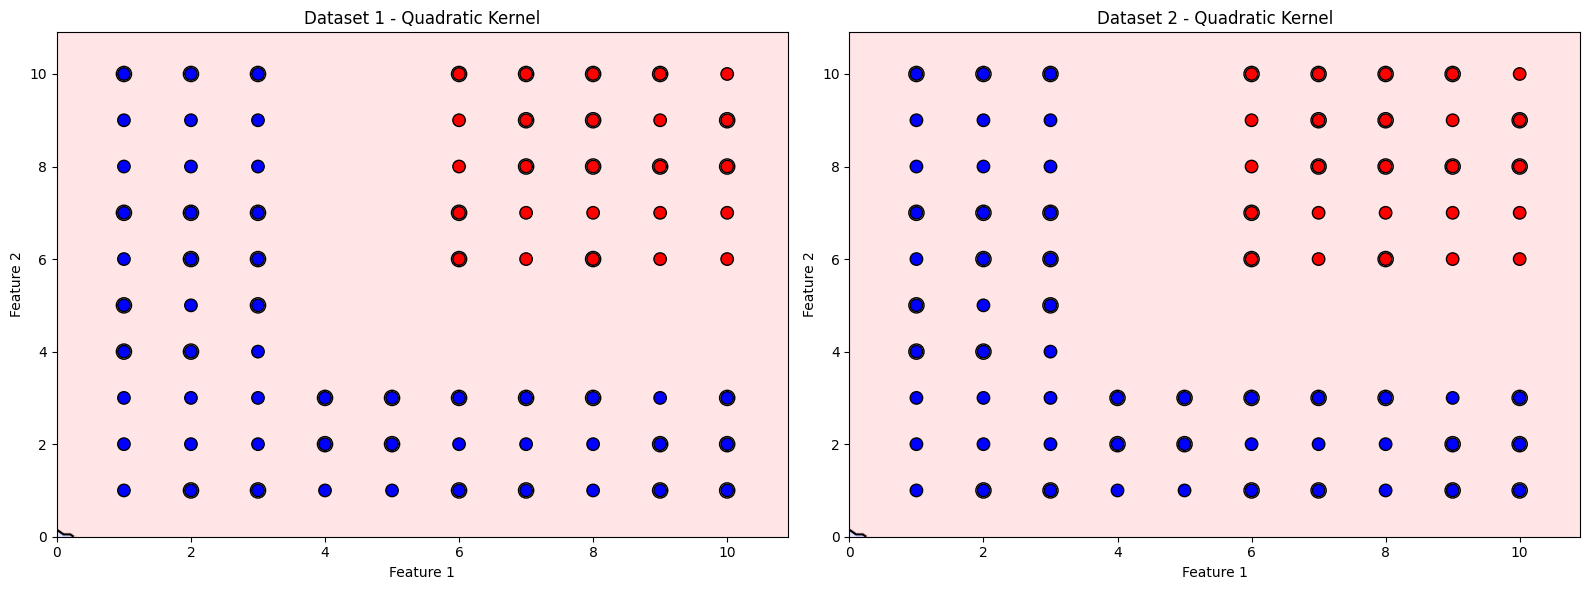


--- Part (b): RBF Kernel ---
Training on dataset 1 with RBF kernel (sigma=1.0)...


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

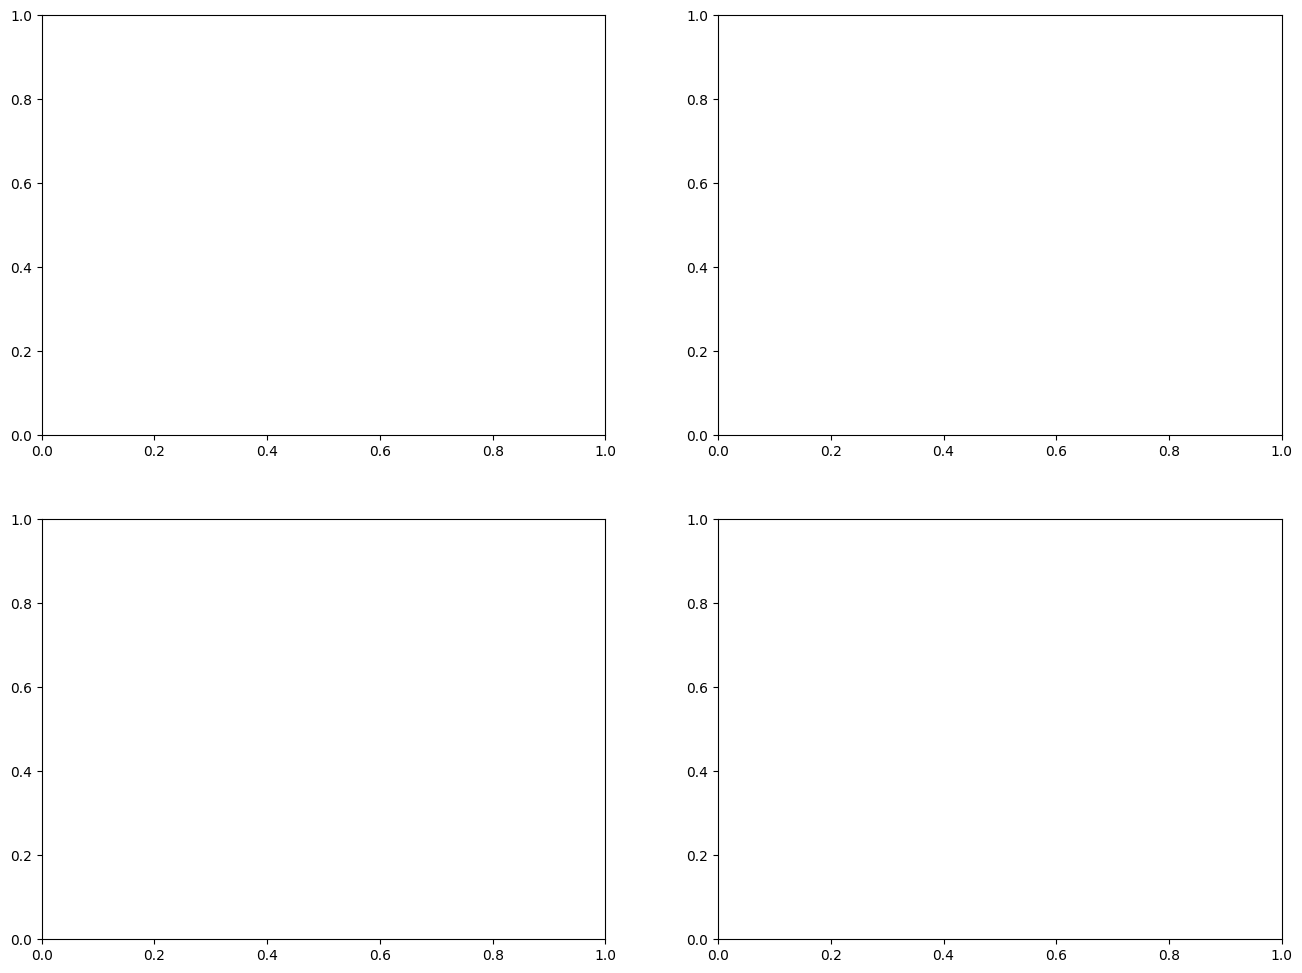

In [34]:
def classify(x, y, alpha, b, xi, kernel_function, c=1.0):
    """
    Classify a new data point using the kernel perceptron.
    
    Args:
        x: Training data
        y: Training labels
        alpha: Weight vector
        b: Bias term
        xi: New data point to classify
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        
    Returns:
        Predicted label (-1 or 1)
    """
    kernel_vals = np.array([kernel_function(xj, xi, c) for xj in x])
    decision_val = np.dot(alpha*y, kernel_vals) + b
    return 1 if decision_val >= 0 else -1

def plot_decision_boundary(x, y, alpha, b, kernel_function, c, ax, title):
    """
    Plot the decision boundary of a kernel perceptron model on a given axis.
    
    Args:
        x: Training data
        y: Training labels
        alpha: Weight vector
        b: Bias term
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        ax: Matplotlib axis to plot on
        title: Plot title
    """
    # Set plot boundaries
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    # Create a mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Predict on the mesh grid
    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            xi = np.array([xx[i, j], yy[i, j]])
            Z[i, j] = classify(x, y, alpha, b, xi, kernel_function, c)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    ax.contour(xx, yy, Z, colors='k', linestyles=['-'], levels=[0])
    
    # Plot data points
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), 
               edgecolors='k', s=80)
    
    # Highlight support vectors
    support_vectors = np.where(alpha > 0)[0]
    ax.scatter(x[support_vectors, 0], x[support_vectors, 1], 
              s=120, linewidth=1, facecolors='none', edgecolors='k')
    
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    return ax

def main():
    # Part (a): Quadratic kernel - 1x2 subplot
    print("\n--- Part (a): Quadratic Kernel ---")
    fig_a, axs_a = plt.subplots(1, 2, figsize=(16, 6))
    
    print("Training on dataset 1 with quadratic kernel...")
    alpha1_quad, b1_quad, updates1_quad = train(x1, y1, quadratic_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_quad, b1_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[0], title="Dataset 1 - Quadratic Kernel")
    
    print("Training on dataset 2 with quadratic kernel...")
    alpha2_quad, b2_quad, updates2_quad = train(x2, y2, quadratic_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_quad, b2_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[1], title="Dataset 2 - Quadratic Kernel")
    
    plt.tight_layout()
    #plt.savefig("part_a_quadratic_kernel.png", dpi=300)
    plt.show()
    
    # Part (b): RBF kernel - 2x2 subplot
    print("\n--- Part (b): RBF Kernel ---")
    fig_b, axs_b = plt.subplots(2, 2, figsize=(16, 12))
    
    # Sigma = 1.0
    print("Training on dataset 1 with RBF kernel (sigma=1.0)...")
    alpha1_rbf1, b1_rbf1, updates1_rbf1 = train(x1, y1, rbf_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_rbf1, b1_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 0], title="Dataset 1 - RBF Kernel (sigma=1.0)")
    
    print("Training on dataset 2 with RBF kernel (sigma=1.0)...")
    alpha2_rbf1, b2_rbf1, updates2_rbf1 = train(x2, y2, rbf_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_rbf1, b2_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 1], title="Dataset 2 - RBF Kernel (sigma=1.0)")
    
    # Sigma = 0.1
    print("Training on dataset 1 with RBF kernel (sigma=0.1)...")
    alpha1_rbf2, b1_rbf2, updates1_rbf2 = train(x1, y1, rbf_kernel, c=0.1)
    plot_decision_boundary(x1, y1, alpha1_rbf2, b1_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 0], title="Dataset 1 - RBF Kernel (sigma=0.1)")
    
    print("Training on dataset 2 with RBF kernel (sigma=0.1)...")
    alpha2_rbf2, b2_rbf2, updates2_rbf2 = train(x2, y2, rbf_kernel, c=0.1)
    plot_decision_boundary(x2, y2, alpha2_rbf2, b2_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 1], title="Dataset 2 - RBF Kernel (sigma=0.1)")
    
    plt.tight_layout()
    #plt.savefig("part_b_rbf_kernel.png", dpi=300)
    plt.show()


main()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from matplotlib.colors import ListedColormap

## load data from data1.txt and data2.txt
data1 = np.loadtxt('data1.txt')  # Removed dtype=int to handle floating-point values
data2 = np.loadtxt('data2.txt')

# initialize x1,y1 from data1.txt
x1 = data1[:, :2]
y1 = data1[:, 2]

# initialize x2,y2 from data2.txt
x2 = data2[:, :2]  # Fixed: was using data1 instead of data2
y2 = data2[:, 2]   # Fixed: was using data1 instead of data2

## define quadratic kernel function
def quadratic_kernel(x, z, c=1.0):
    ## quadratic kernel function
    return (np.dot(x, z) + c)**2

## define rbf kernel function
def rbf_kernel(x, z, c=1.0):
    ## rbf kernel function
    return np.exp(-np.linalg.norm(x - z)**2 / (2 * c**2))

# this is your train function
def train(x, y, kernel_function, c=1.0, track_updates=True, set_seed=True):
    if set_seed:
        x, y = shuffle(x, y, random_state=42)
    else:
        x, y = shuffle(x, y)
    
    alpha = np.zeros(x.shape[0])
    b = 0
    updates = 0
    max_updates = 1000
    
    # this is your classify
    def make_prediction(x, y, alpha, b, updates, kernel_function, c=c):
        error = False    
        for i, (xi, yi) in enumerate(zip(x, y)):
            kernel_vals = np.array([kernel_function(xj, xi, c) for xj in x])
            decision_val = np.dot(alpha*y, kernel_vals) + b  # this is your kernel function
            predicted_y = 1 if decision_val >= 0 else -1
            if predicted_y != yi:
                alpha[i] += 1
                b += yi
                updates += 1
                error = True  
        
        if updates <= max_updates:
            if error:
                return make_prediction(x, y, alpha, b, updates, kernel_function, c=c) 
            else:
                return (alpha, b, updates)
        else:
            print(f"Did not converge after {max_updates} iterations")
            return (alpha, b, updates)
    
    if track_updates:
        alpha, b, updates = make_prediction(x, y, alpha, b, updates, kernel_function, c=c)
        print(f"Number of updates: {updates}")
        print(f"Number of support vectors: {np.sum(alpha > 0)}")
        return (alpha, b, updates)
    else:
        alpha, b, updates = make_prediction(x, y, alpha, b, updates, kernel_function, c=c)
        print(f"Number of updates: {updates}")
        print(f"Number of support vectors: {np.sum(alpha > 0)}")
        return (alpha, b)

def classify(x, y, alpha, b, xi, kernel_function, c=1.0):
    """
    Classify a new data point using the kernel perceptron.
    
    Args:
        x: Training data
        y: Training labels
        alpha: Weight vector
        b: Bias term
        xi: New data point to classify
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        
    Returns:
        Predicted label (-1 or 1)
    """
    kernel_vals = np.array([kernel_function(xj, xi, c) for xj in x])
    decision_val = np.dot(alpha*y, kernel_vals) + b
    return 1 if decision_val >= 0 else -1

def plot_decision_boundary(x, y, alpha, b, kernel_function, c, ax, title):
    """
    Plot the decision boundary of a kernel perceptron model on a given axis.
    
    Args:
        x: Training data
        y: Training labels
        alpha: Weight vector
        b: Bias term
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        ax: Matplotlib axis to plot on
        title: Plot title
    """
    # Set plot boundaries
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    # Create a mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Predict on the mesh grid
    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            xi = np.array([xx[i, j], yy[i, j]])
            Z[i, j] = classify(x, y, alpha, b, xi, kernel_function, c)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    ax.contour(xx, yy, Z, colors='k', linestyles=['-'], levels=[0])
    
    # Plot data points
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), 
               edgecolors='k', s=80)
    
    # Highlight support vectors
    support_vectors = np.where(alpha > 0)[0]
    ax.scatter(x[support_vectors, 0], x[support_vectors, 1], 
              s=120, linewidth=1, facecolors='none', edgecolors='k')
    
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    return ax

def main():
    # Part (a): Quadratic kernel - 1x2 subplot
    print("\n--- Part (a): Quadratic Kernel ---")
    fig_a, axs_a = plt.subplots(1, 2, figsize=(16, 6))
    
    print("Training on dataset 1 with quadratic kernel...")
    alpha1_quad, b1_quad, updates1_quad = train(x1, y1, quadratic_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_quad, b1_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[0], title="Dataset 1 - Quadratic Kernel")
    
    print("Training on dataset 2 with quadratic kernel...")
    alpha2_quad, b2_quad, updates2_quad = train(x2, y2, quadratic_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_quad, b2_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[1], title="Dataset 2 - Quadratic Kernel")
    
    plt.tight_layout()
    #plt.savefig("part_a_quadratic_kernel.png", dpi=300)
    plt.show()
    
    # Part (b): RBF kernel - 2x2 subplot
    print("\n--- Part (b): RBF Kernel ---")
    fig_b, axs_b = plt.subplots(2, 2, figsize=(16, 12))
    
    # Sigma = 1.0
    print("Training on dataset 1 with RBF kernel (sigma=1.0)...")
    alpha1_rbf1, b1_rbf1, updates1_rbf1 = train(x1, y1, rbf_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_rbf1, b1_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 0], title="Dataset 1 - RBF Kernel (sigma=1.0)")
    
    print("Training on dataset 2 with RBF kernel (sigma=1.0)...")
    alpha2_rbf1, b2_rbf1, updates2_rbf1 = train(x2, y2, rbf_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_rbf1, b2_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 1], title="Dataset 2 - RBF Kernel (sigma=1.0)")
    
    # Sigma = 0.1
    print("Training on dataset 1 with RBF kernel (sigma=0.1)...")
    alpha1_rbf2, b1_rbf2, updates1_rbf2 = train(x1, y1, rbf_kernel, c=0.1)
    plot_decision_boundary(x1, y1, alpha1_rbf2, b1_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 0], title="Dataset 1 - RBF Kernel (sigma=0.1)")
    
    print("Training on dataset 2 with RBF kernel (sigma=0.1)...")
    alpha2_rbf2, b2_rbf2, updates2_rbf2 = train(x2, y2, rbf_kernel, c=0.1)
    plot_decision_boundary(x2, y2, alpha2_rbf2, b2_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 1], title="Dataset 2 - RBF Kernel (sigma=0.1)")
    
    plt.tight_layout()
    #plt.savefig("part_b_rbf_kernel.png", dpi=300)
    plt.show()


main()


--- Part (a): Quadratic Kernel ---
Training on dataset 1 with quadratic kernel...
Converged!
Number of support vectors: 17
[5. 5. 4. 4. 1. 0. 0. 0. 0. 0. 4. 4. 2. 1. 0. 0. 0. 0. 0. 0. 3. 3. 2. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 7. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] 36.0


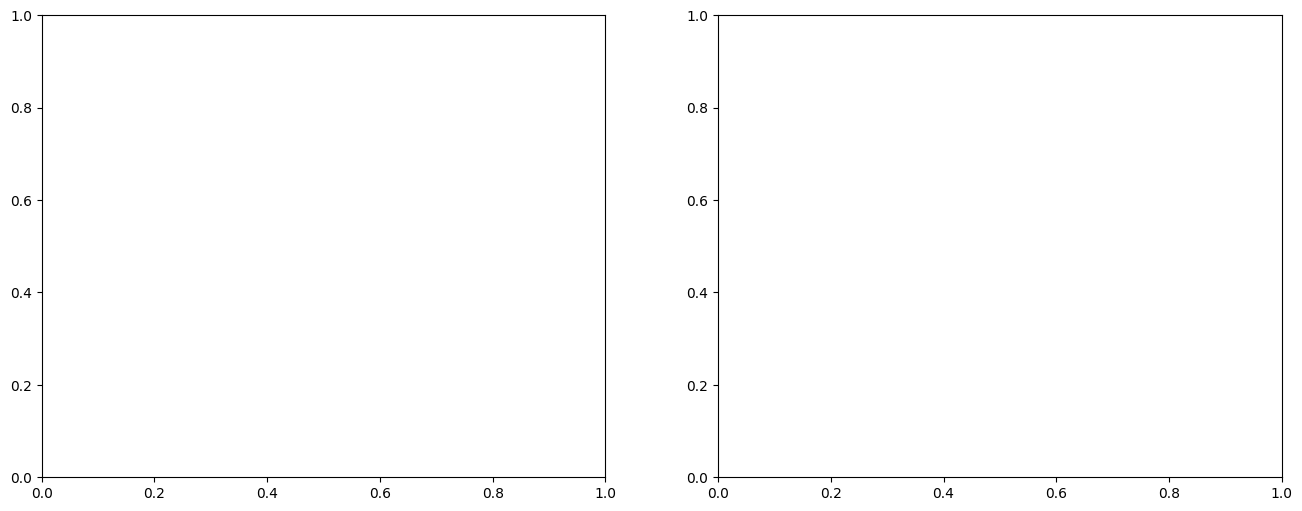

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def quadratic_kernel(x, z, c):
    """
    Quadratic kernel: K(x, z) = (x·z + c)²
    
    Args:
        x: First data point (shape: (n_features,))
        z: Second data point (shape: (n_features,))
        c: Constant term added before squaring
        
    Returns:
        Kernel value
    """
    return (np.dot(x, z) + c)**2

def rbf_kernel(x, z, c):
    """
    RBF kernel: K(x, z) = exp(-||x-z||²/(2*c²))
    
    Args:
        x: First data point (shape: (n_features,))
        z: Second data point (shape: (n_features,))
        c: Width parameter of the RBF kernel (sigma)
        
    Returns:
        Kernel value
    """
    return np.exp(-np.linalg.norm(x-z)**2/(2*c**2))

def train(x, y, kernel_function, c=1.0, max_iter=1000):
    """
    Train a kernel perceptron.
    
    Args:
        x: Training data of shape (n_samples, n_features)
        y: Training labels of shape (n_samples,)
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        max_iter: Maximum number of iterations
        
    Returns:
        alpha: Weight vector
        b: Bias term
    """
    n_samples = len(x)
    alpha = np.zeros(n_samples)
    b = 0
    
    # Precompute kernel matrix for efficiency
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel_function(x[i], x[j], c)
    
    # Training loop
    for _ in range(max_iter):
        mistakes = False
        
        for i in range(n_samples):
            # Compute prediction
            f_xi = 0
            for j in range(n_samples):
                f_xi += alpha[j] * y[j] * K[i, j]
            f_xi += b
            
            # Update if misclassified
            if y[i] * f_xi <= 0:
                alpha[i] += 1
                b += y[i]
                mistakes = True
        
        # If no mistakes were made, we're done
        if not mistakes:
            print("Converged!")
            break
    
    # Count support vectors
    support_vectors = np.sum(alpha > 0)
    print(f"Number of support vectors: {support_vectors}")
    
    return alpha, b

def classify(x, y, alpha, b, xi, kernel_function, c=1.0):
    """
    Classify a new data point using the kernel perceptron.
    
    Args:
        x: Training data of shape (n_samples, n_features)
        y: Training labels of shape (n_samples,)
        alpha: Weight vector
        b: Bias term
        xi: New data point to classify
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        
    Returns:
        Predicted label (-1 or 1)
    """
    f_xi = 0
    for i in range(len(x)):
        f_xi += alpha[i] * y[i] * kernel_function(x[i], xi, c)
    f_xi += b
    
    return 1 if f_xi >= 0 else -1

def plot_decision_boundary(x, y, alpha, b, kernel_function, c, ax, title):
    """
    Plot the decision boundary of a kernel perceptron model on a given axis.
    
    Args:
        x: Training data
        y: Training labels
        alpha: Weight vector
        b: Bias term
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        ax: Matplotlib axis to plot on
        title: Plot title
    """
    # Set plot boundaries
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    # Create a mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Predict on the mesh grid
    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            xi = np.array([xx[i, j], yy[i, j]])
            Z[i, j] = classify(x, y, alpha, b, xi, kernel_function, c)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    ax.contour(xx, yy, Z, colors='k', linestyles=['-'], levels=[0])
    
    # Plot data points
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), 
               edgecolors='k', s=80)
    
    # Highlight support vectors
    support_vectors = np.where(alpha > 0)[0]
    ax.scatter(x[support_vectors, 0], x[support_vectors, 1], 
              s=120, linewidth=1, facecolors='none', edgecolors='k')
    
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    return ax

def main():
    # Load data
    data1 = np.loadtxt('data1.txt')
    data2 = np.loadtxt('data2.txt')
    
    # Extract features and labels
    x1 = data1[:, :2]
    y1 = data1[:, 2]
    
    x2 = data2[:, :2]
    y2 = data2[:, 2]
    
    # Part (a): Quadratic kernel - 1x2 subplot
    print("\n--- Part (a): Quadratic Kernel ---")
    fig_a, axs_a = plt.subplots(1, 2, figsize=(16, 6))
    
    print("Training on dataset 1 with quadratic kernel...")
    alpha1_quad, b1_quad = train(x1, y1, quadratic_kernel, c=1.0)
    print(alpha1_quad, b1_quad)
    
    plot_decision_boundary(x1, y1, alpha1_quad, b1_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[0], title="Dataset 1 - Quadratic Kernel")
    
    print("Training on dataset 2 with quadratic kernel...")
    alpha2_quad, b2_quad = train(x2, y2, quadratic_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_quad, b2_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[1], title="Dataset 2 - Quadratic Kernel")
    
    plt.tight_layout()
    #plt.savefig("part_a_quadratic_kernel.png", dpi=300)
    plt.show()
    
    # Part (b): RBF kernel - 2x2 subplot
    print("\n--- Part (b): RBF Kernel ---")
    fig_b, axs_b = plt.subplots(2, 2, figsize=(16, 12))
    
    # Sigma = 1.0
    print("Training on dataset 1 with RBF kernel (sigma=1.0)...")
    alpha1_rbf1, b1_rbf1 = train(x1, y1, rbf_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_rbf1, b1_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 0], title="Dataset 1 - RBF Kernel (sigma=1.0)")
    
    print("Training on dataset 2 with RBF kernel (sigma=1.0)...")
    alpha2_rbf1, b2_rbf1 = train(x2, y2, rbf_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_rbf1, b2_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 1], title="Dataset 2 - RBF Kernel (sigma=1.0)")
    
    # Sigma = 0.1
    print("Training on dataset 1 with RBF kernel (sigma=0.1)...")
    alpha1_rbf2, b1_rbf2 = train(x1, y1, rbf_kernel, c=0.1)
    plot_decision_boundary(x1, y1, alpha1_rbf2, b1_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 0], title="Dataset 1 - RBF Kernel (sigma=0.1)")
    
    print("Training on dataset 2 with RBF kernel (sigma=0.1)...")
    alpha2_rbf2, b2_rbf2 = train(x2, y2, rbf_kernel, c=0.1)
    plot_decision_boundary(x2, y2, alpha2_rbf2, b2_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 1], title="Dataset 2 - RBF Kernel (sigma=0.1)")
    
    plt.tight_layout()
    #plt.savefig("part_b_rbf_kernel.png", dpi=300)
    plt.show()

main()

In [ ]:
import numpy as np
from sklearn.utils import shuffle
## load data from data1.txt and data2.txt
data1 = np.loadtxt('data1.txt', dtype=int)
data2 = np.loadtxt('data2.txt', dtype=int)

# initalize x1,y1 from data1.txt
x1 = data1[:, :2]
y1 = data1[:, 2]

# initalize x2,y2 from data2.txt
x2 = data2[:, :2]
y2 = data2[:, 2]

def quadratic_kernel(x, z, c=1.0):
    ## quadratic kernel function
    return (np.dot(x, z) + c)**2

def rbf_kernel(x,z, c=1.0):
    ## rbf kernel function
    return np.exp(-np.linalg.norm(x - z)**2 / (2 * c**2))

def train(x, y, kernel_function, c=1.0, max_iter=1000):
    """
    Train a kernel perceptron.
    
    Args:
        x: Training data of shape (n_samples, n_features)
        y: Training labels of shape (n_samples,)
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        max_iter: Maximum number of iterations
        
    Returns:
        alpha: Weight vector
        b: Bias term
    """
    n_samples = len(x)
    alpha = np.zeros(n_samples)
    b = 0
    
    # Precompute kernel matrix for efficiency
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel_function(x[i], x[j], c)
    
    # Training loop
    for _ in range(max_iter):
        mistakes = False
        
        for i in range(n_samples):
            # Compute prediction
            f_xi = 0
            for j in range(n_samples):
                f_xi += alpha[j] * y[j] * K[i, j]
            f_xi += b
            
            # Update if misclassified
            if y[i] * f_xi <= 0:
                alpha[i] += 1
                b += y[i]
                mistakes = True
        
        # If no mistakes were made, we're done
        if not mistakes:
            print("Converged!")
            break
    
    # Count support vectors
    support_vectors = np.sum(alpha > 0)
    print(f"Number of support vectors: {support_vectors}")
    
    return alpha, b

def classify(x, y, alpha, b, xi, kernel_function, c=1.0):
    """
    Classify a new data point using the kernel perceptron.
    
    Args:
        x: Training data of shape (n_samples, n_features)
        y: Training labels of shape (n_samples,)
        alpha: Weight vector
        b: Bias term
        xi: New data point to classify
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        
    Returns:
        Predicted label (-1 or 1)
    """
    f_xi = 0
    for i in range(len(x)):
        f_xi += alpha[i] * y[i] * kernel_function(x[i], xi, c)
    f_xi += b
    
    return 1 if f_xi >= 0 else -1

def kernel_peceptron(alpha, b, kernel_type, x, y):
    x = x[:,0]
    z = x[:,1]
    kernel_result = np.sum(alpha*y*kernel_type(x,z)) + b
    if kernel_result >= 0:
        label = 1
    else:
        label = -1
    return(label)
    

def fit_kernel_perceptron(x, y, track_updates, kernel_type, set_seed):
    if set_seed:
        x, y = shuffle(x, y,random_state=42)
    else:
        x, y = shuffle(x, y)
    alpha = np.zeros(x.shape[0])
    b = 0
    updates = 0
    max_updates = 1000


    def make_prediction(alpha, b, x, y, kernel_type, updates):
        error = False    
        for xi, yi in zip(x, y):
            if kernel_perceptron(alpha, b, kernel_type, xi, yi) != yi:
                alpha[yi] += 1
                b += yi
                updates += 1
                error = True  
        if updates <= max_updates:
            if error:
                return make_prediction(alpha, b, x, y, kernel_type, updates) 
            else:
                return (alpha, b, updates)
        else:
            print("Did not converge after {max_iterations} iterations")
    if track_updates:
        alpha, b, updates = make_prediction(alpha, b, x, y, kernel_type, updates)
        return (alpha, b, updates)
    else:
        alpha, b, updates = make_prediction(alpha, b, x, y, kernel_type, updates)
        return (alpha, b)






--- Part (a): Quadratic Kernel ---
Training on dataset 1 with quadratic kernel...
Converged!
Number of support vectors: 17
Training on dataset 2 with quadratic kernel...
Number of support vectors: 45


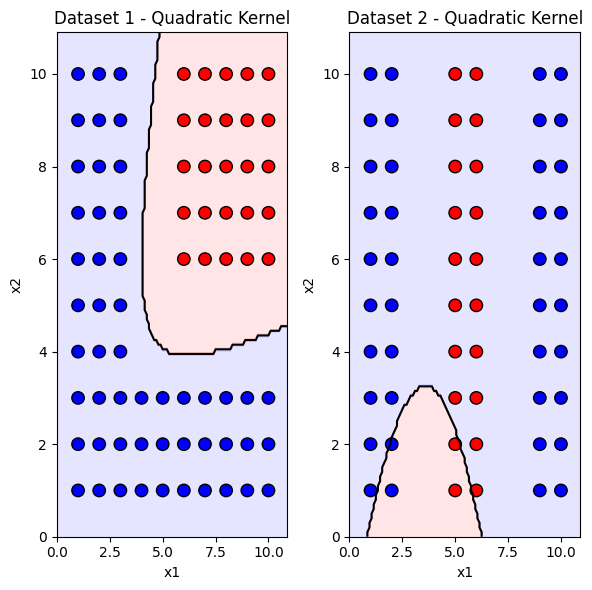


--- Part (b): RBF Kernel ---
Training on dataset 1 with RBF kernel (sigma=1.0)...
Converged!
Number of support vectors: 7
Training on dataset 2 with RBF kernel (sigma=1.0)...
Converged!
Number of support vectors: 3
Training on dataset 1 with RBF kernel (sigma=0.1)...
Converged!
Number of support vectors: 12
Training on dataset 2 with RBF kernel (sigma=0.1)...
Converged!
Number of support vectors: 11


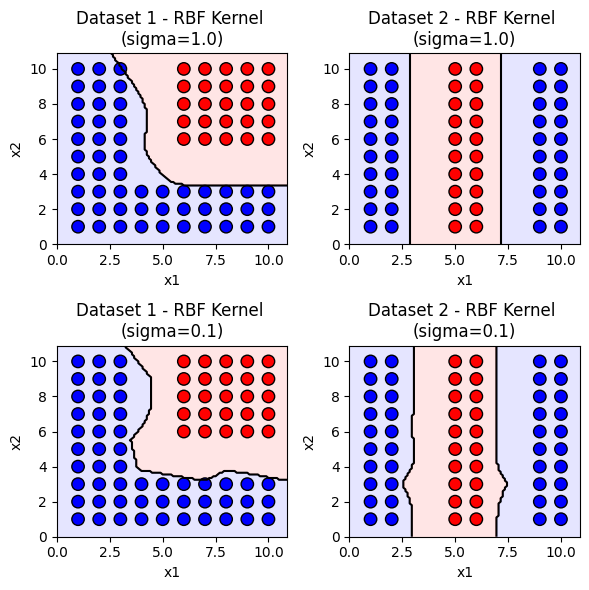

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def quadratic_kernel(x, z, c):
    """
    Quadratic kernel: K(x, z) = (x·z + c)²
    
    Args:
        x: First data point (shape: (n_features,))
        z: Second data point (shape: (n_features,))
        c: Constant term added before squaring
        
    Returns:
        Kernel value
    """
    return (np.dot(x, z) + c)**2

def rbf_kernel(x, z, c):
    """
    RBF kernel: K(x, z) = exp(-||x-z||²/(2*c²))
    
    Args:
        x: First data point (shape: (n_features,))
        z: Second data point (shape: (n_features,))
        c: Width parameter of the RBF kernel (sigma)
        
    Returns:
        Kernel value
    """
    return np.exp(-np.linalg.norm(x-z)**2/(2*c**2))

def train(x, y, kernel_function, c=1.0, max_iter=1000):
    """
    Train a kernel perceptron.
    
    Args:
        x: Training data of shape (n_samples, n_features)
        y: Training labels of shape (n_samples,)
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        max_iter: Maximum number of iterations
        
    Returns:
        alpha: Weight vector
        b: Bias term
    """
    n_samples = len(x)
    alpha = np.zeros(n_samples)
    b = 0
    
    # Precompute kernel matrix for efficiency
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel_function(x[i], x[j], c)
    
    # Training loop
    for _ in range(max_iter):
        mistakes = False
        
        for i in range(n_samples):
            # Compute prediction
            f_xi = 0
            for j in range(n_samples):
                f_xi += alpha[j] * y[j] * K[i, j]
            f_xi += b
            
            # Update if misclassified
            if y[i] * f_xi <= 0:
                alpha[i] += 1
                b += y[i]
                mistakes = True
        
        # If no mistakes were made, we're done
        if not mistakes:
            print("Converged!")
            break
    
    # Count support vectors
    support_vectors = np.sum(alpha > 0)
    print(f"Number of support vectors: {support_vectors}")
    
    return alpha, b

def classify(x, y, alpha, b, xi, kernel_function, c=1.0):
    """
    Classify a new data point using the kernel perceptron.
    
    Args:
        x: Training data of shape (n_samples, n_features)
        y: Training labels of shape (n_samples,)
        alpha: Weight vector
        b: Bias term
        xi: New data point to classify
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        
    Returns:
        Predicted label (-1 or 1)
    """
    f_xi = 0
    for i in range(len(x)):
        f_xi += alpha[i] * y[i] * kernel_function(x[i], xi, c)
    f_xi += b
    
    return 1 if f_xi >= 0 else -1

def plot_decision_boundary(x, y, alpha, b, kernel_function, c, ax, title):
    """
    Plot the decision boundary of a kernel perceptron model on a given axis.
    
    Args:
        x: Training data
        y: Training labels
        alpha: Weight vector
        b: Bias term
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        ax: Matplotlib axis to plot on
        title: Plot title
    """
    # Set plot boundaries
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    # Create a mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Predict on the mesh grid
    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            xi = np.array([xx[i, j], yy[i, j]])
            Z[i, j] = classify(x, y, alpha, b, xi, kernel_function, c)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    ax.contour(xx, yy, Z, colors='k', linestyles=['-'], levels=[0])
    
    # Plot data points
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), 
               edgecolors='k', s=80)

    ax.set_title(title)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    
    return ax

def main():
    # Load data
    data1 = np.loadtxt('data1.txt')
    data2 = np.loadtxt('data2.txt')
    
    # Extract features and labels
    x1 = data1[:, :2]
    y1 = data1[:, 2]
    
    x2 = data2[:, :2]
    y2 = data2[:, 2]
    
    # Part (a): Quadratic kernel - 1x2 subplot
    print("\n--- Part (a): Quadratic Kernel ---")
    fig_a, axs_a = plt.subplots(1, 2, figsize=(6, 6))
    
    print("Training on dataset 1 with quadratic kernel...")
    alpha1_quad, b1_quad = train(x1, y1, quadratic_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_quad, b1_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[0], title="Dataset 1 - Quadratic Kernel")
    
    print("Training on dataset 2 with quadratic kernel...")
    alpha2_quad, b2_quad = train(x2, y2, quadratic_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_quad, b2_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[1], title="Dataset 2 - Quadratic Kernel")
    
    plt.tight_layout()
    plt.savefig("part_a_quadratic_kernel.png", dpi=300)
    plt.show()
    
    # Part (b): RBF kernel - 2x2 subplot
    print("\n--- Part (b): RBF Kernel ---")
    fig_b, axs_b = plt.subplots(2, 2, figsize=(6, 6))
    
    # Sigma = 1.0
    print("Training on dataset 1 with RBF kernel (sigma=1.0)...")
    alpha1_rbf1, b1_rbf1 = train(x1, y1, rbf_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_rbf1, b1_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 0], title="Dataset 1 - RBF Kernel \n(sigma=1.0)")
    
    print("Training on dataset 2 with RBF kernel (sigma=1.0)...")
    alpha2_rbf1, b2_rbf1 = train(x2, y2, rbf_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_rbf1, b2_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 1], title="Dataset 2 - RBF Kernel \n(sigma=1.0)")
    
    # Sigma = 0.1
    print("Training on dataset 1 with RBF kernel (sigma=0.1)...")
    alpha1_rbf2, b1_rbf2 = train(x1, y1, rbf_kernel, c=0.1)
    plot_decision_boundary(x1, y1, alpha1_rbf2, b1_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 0], title="Dataset 1 - RBF Kernel \n(sigma=0.1)")
    
    print("Training on dataset 2 with RBF kernel (sigma=0.1)...")
    alpha2_rbf2, b2_rbf2 = train(x2, y2, rbf_kernel, c=0.1)
    plot_decision_boundary(x2, y2, alpha2_rbf2, b2_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 1], title="Dataset 2 - RBF Kernel \n(sigma=0.1)")
    
    plt.tight_layout()
    plt.savefig("part_b_rbf_kernel.png", dpi=300)
    plt.show()

main()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def quadratic_kernel(x, z, c):
    return (np.dot(x, z) + c)**2

def rbf_kernel(x, z, c):
    return np.exp(-np.linalg.norm(x-z)**2/(2*c**2))

def train(x, y, kernel_function, c=1.0, max_iter=1000):
    n_samples = len(x)
    alpha = np.zeros(n_samples)
    b = 0
    
    ## calculate kernel matrix before looping through dataset
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel_function(x[i], x[j], c)
    
    ## training loop for max iterations
    for _ in range(max_iter):
        mistakes = False
        
        for i in range(n_samples):
            ## calculate predicted label
            f_xi = 0
            for j in range(n_samples):
                f_xi += alpha[j] * y[j] * K[i, j]
            f_xi += b
            
            ## update b and alpha if prediction is wrong
            if y[i] * f_xi <= 0:
                alpha[i] += 1
                b += y[i]
                mistakes = True
        
        ## stop training loop if all predictions are correct
        if not mistakes:
            print("converged!")
            break

    return alpha, b

def classify(x, y, alpha, b, xi, kernel_function, c=1.0):
    f_xi = 0
    for i in range(len(x)):
        f_xi += alpha[i] * y[i] * kernel_function(x[i], xi, c)
    f_xi += b
    
    return 1 if f_xi >= 0 else -1

def plot_decision_boundary(x, y, alpha, b, kernel_function, c, ax, title):
    """
    Plot the decision boundary of a kernel perceptron model on a given axis.
    
    Args:
        x: Training data
        y: Training labels
        alpha: Weight vector
        b: Bias term
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        ax: Matplotlib axis to plot on
        title: Plot title
    """
    # Set plot boundaries
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    # Create a mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Predict on the mesh grid
    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            xi = np.array([xx[i, j], yy[i, j]])
            Z[i, j] = classify(x, y, alpha, b, xi, kernel_function, c)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    ax.contour(xx, yy, Z, colors='k', linestyles=['-'], levels=[0])
    
    # Plot data points
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), 
               edgecolors='k', s=80)
    
    # Highlight support vectors
    support_vectors = np.where(alpha > 0)[0]
    ax.scatter(x[support_vectors, 0], x[support_vectors, 1], 
              s=120, linewidth=1, facecolors='none', edgecolors='k')
    
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    return ax

def main():
    # Load data
    data1 = np.loadtxt('data1.txt')
    data2 = np.loadtxt('data2.txt')
    
    # Extract features and labels
    x1 = data1[:, :2]
    y1 = data1[:, 2]
    
    x2 = data2[:, :2]
    y2 = data2[:, 2]
    
    # Part (a): Quadratic kernel - 1x2 subplot
    print("\n--- Part (a): Quadratic Kernel ---")
    fig_a, axs_a = plt.subplots(1, 2, figsize=(16, 6))
    
    print("Training on dataset 1 with quadratic kernel...")
    alpha1_quad, b1_quad = train(x1, y1, quadratic_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_quad, b1_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[0], title="Dataset 1 - Quadratic Kernel")
    
    print("Training on dataset 2 with quadratic kernel...")
    alpha2_quad, b2_quad = train(x2, y2, quadratic_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_quad, b2_quad, quadratic_kernel, c=1.0,
                          ax=axs_a[1], title="Dataset 2 - Quadratic Kernel")
    
    plt.tight_layout()
    #plt.savefig("part_a_quadratic_kernel.png", dpi=300)
    plt.show()
    
    # Part (b): RBF kernel - 2x2 subplot
    print("\n--- Part (b): RBF Kernel ---")
    fig_b, axs_b = plt.subplots(2, 2, figsize=(16, 12))
    
    # Sigma = 1.0
    print("Training on dataset 1 with RBF kernel (sigma=1.0)...")
    alpha1_rbf1, b1_rbf1 = train(x1, y1, rbf_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_rbf1, b1_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 0], title="Dataset 1 - RBF Kernel (sigma=1.0)")
    
    print("Training on dataset 2 with RBF kernel (sigma=1.0)...")
    alpha2_rbf1, b2_rbf1 = train(x2, y2, rbf_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_rbf1, b2_rbf1, rbf_kernel, c=1.0,
                          ax=axs_b[0, 1], title="Dataset 2 - RBF Kernel (sigma=1.0)")
    
    # Sigma = 0.1
    print("Training on dataset 1 with RBF kernel (sigma=0.1)...")
    alpha1_rbf2, b1_rbf2 = train(x1, y1, rbf_kernel, c=0.1)
    plot_decision_boundary(x1, y1, alpha1_rbf2, b1_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 0], title="Dataset 1 - RBF Kernel (sigma=0.1)")
    
    print("Training on dataset 2 with RBF kernel (sigma=0.1)...")
    alpha2_rbf2, b2_rbf2 = train(x2, y2, rbf_kernel, c=0.1)
    plot_decision_boundary(x2, y2, alpha2_rbf2, b2_rbf2, rbf_kernel, c=0.1,
                          ax=axs_b[1, 1], title="Dataset 2 - RBF Kernel (sigma=0.1)")
    
    plt.tight_layout()
    #plt.savefig("part_b_rbf_kernel.png", dpi=300)
    plt.show()

main()


Training on dataset 1 with quadratic kernel...
Converged!
Number of support vectors: 17


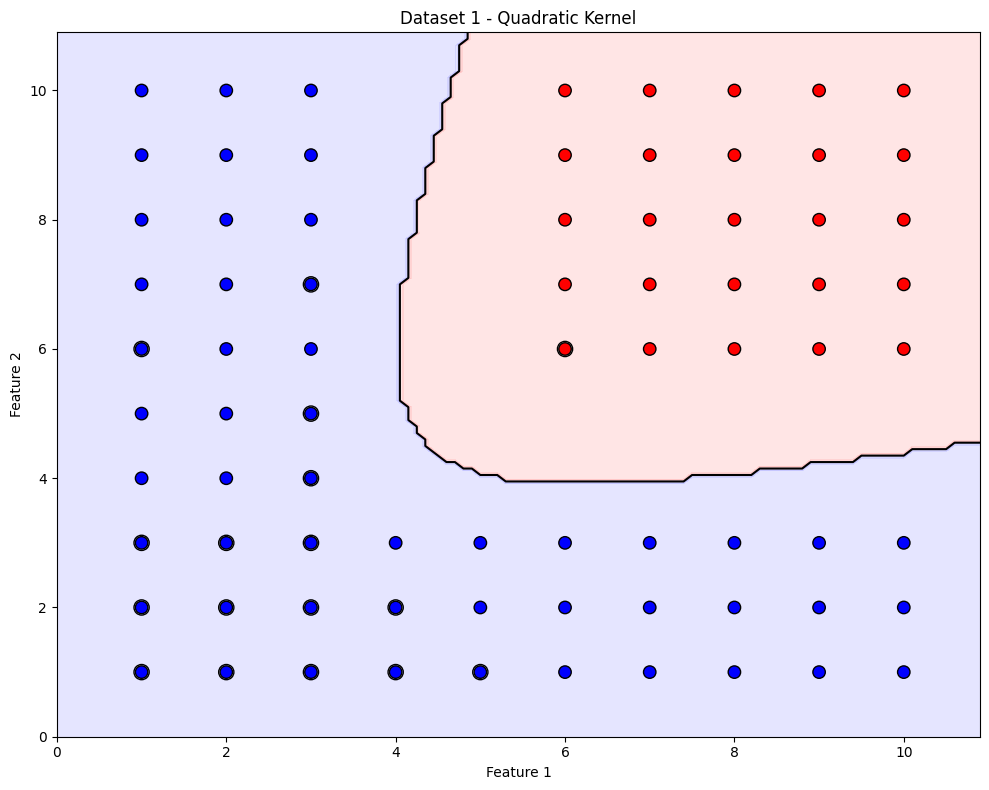


Training on dataset 2 with quadratic kernel...
Number of support vectors: 45


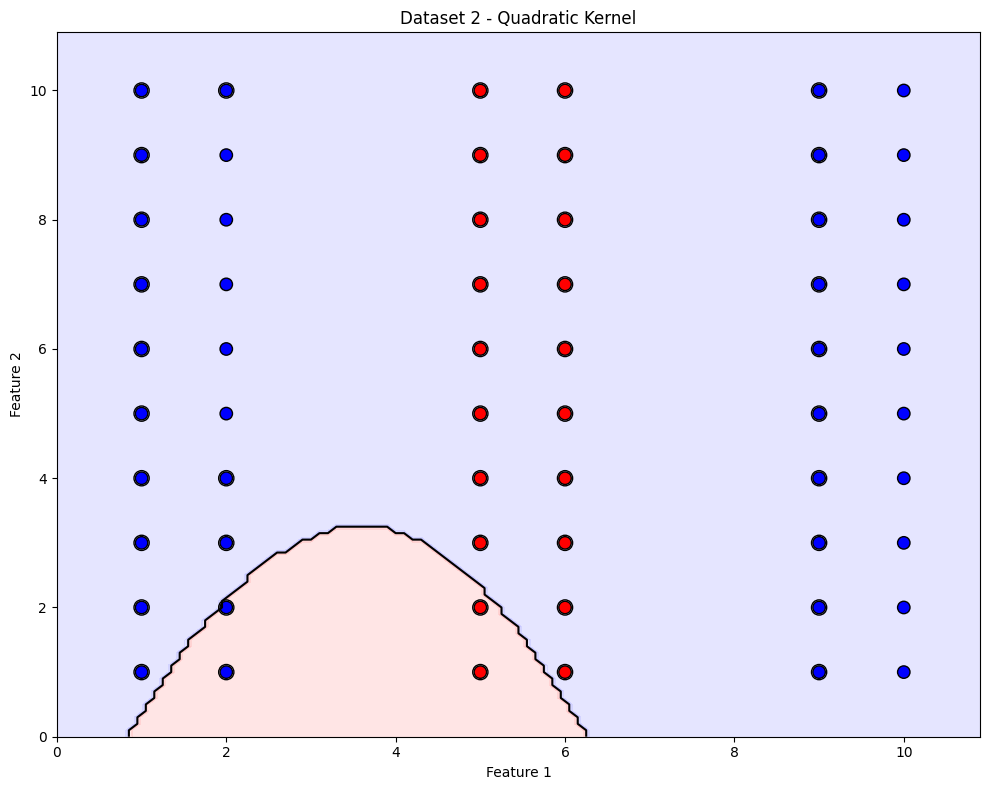


Training on dataset 1 with RBF kernel (sigma=1.0)...
Converged!
Number of support vectors: 7


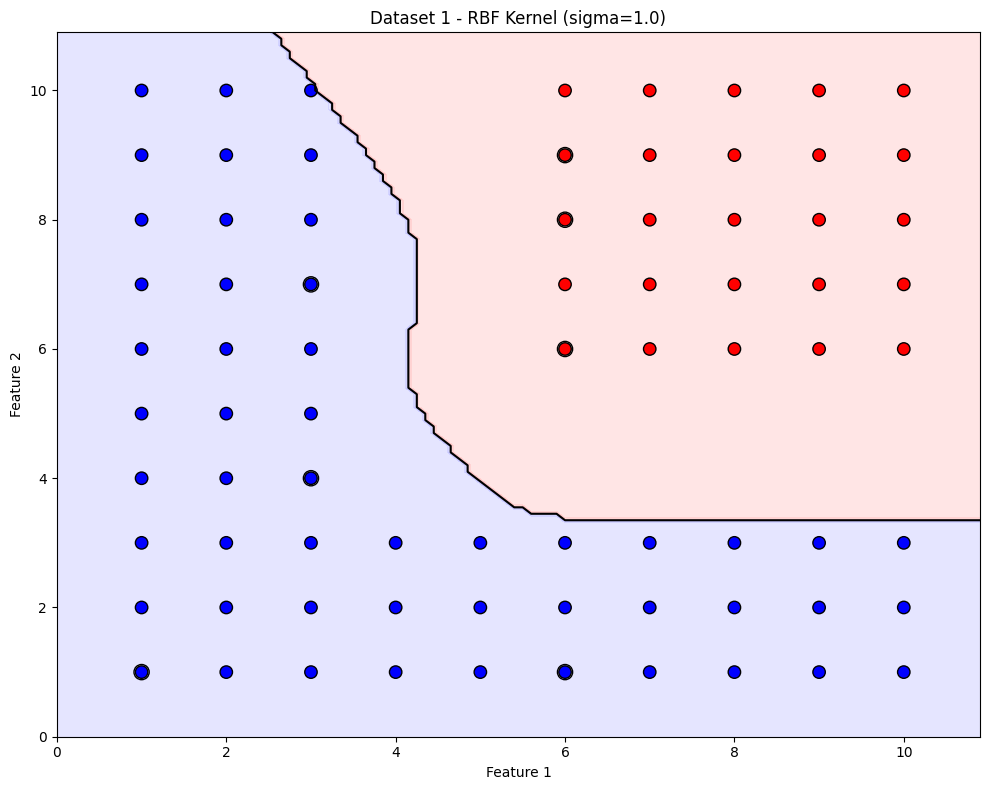


Training on dataset 2 with RBF kernel (sigma=1.0)...
Converged!
Number of support vectors: 3


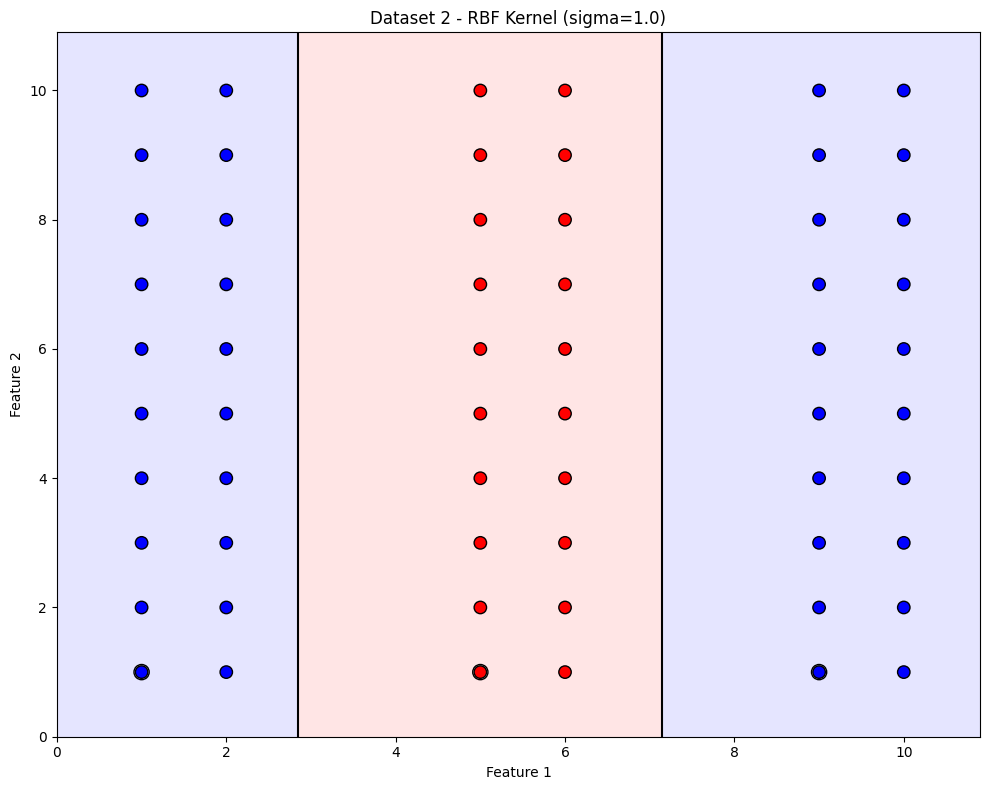


Training on dataset 1 with RBF kernel (sigma=0.1)...
Converged!
Number of support vectors: 12


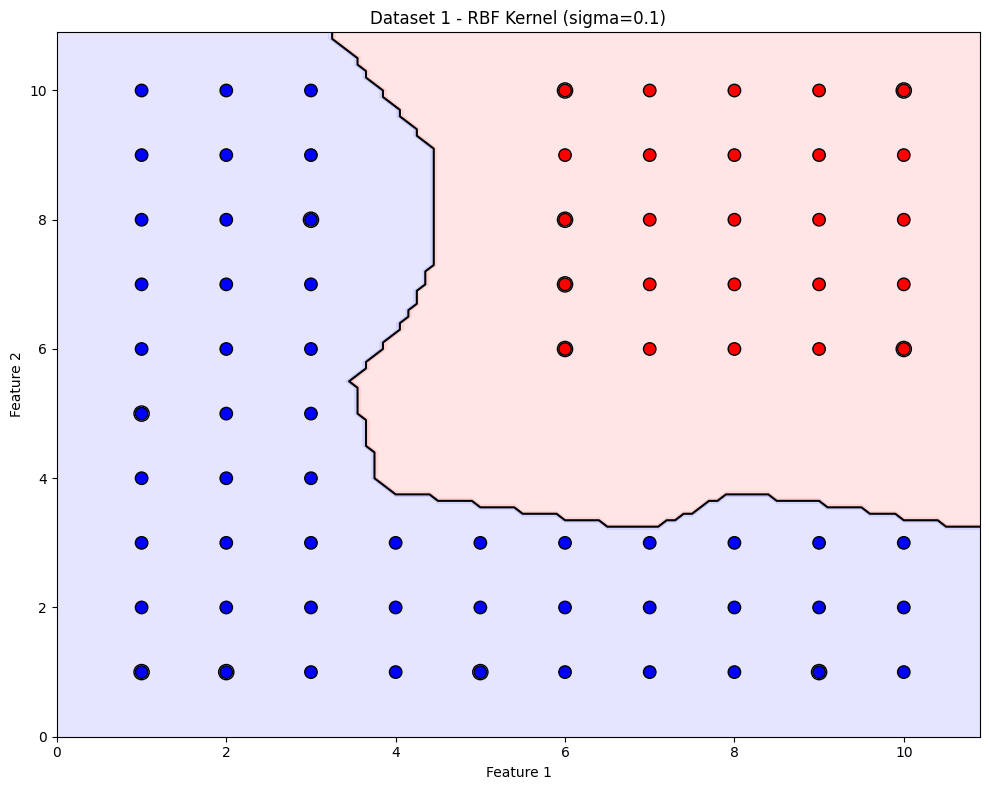


Training on dataset 2 with RBF kernel (sigma=0.1)...
Converged!
Number of support vectors: 11


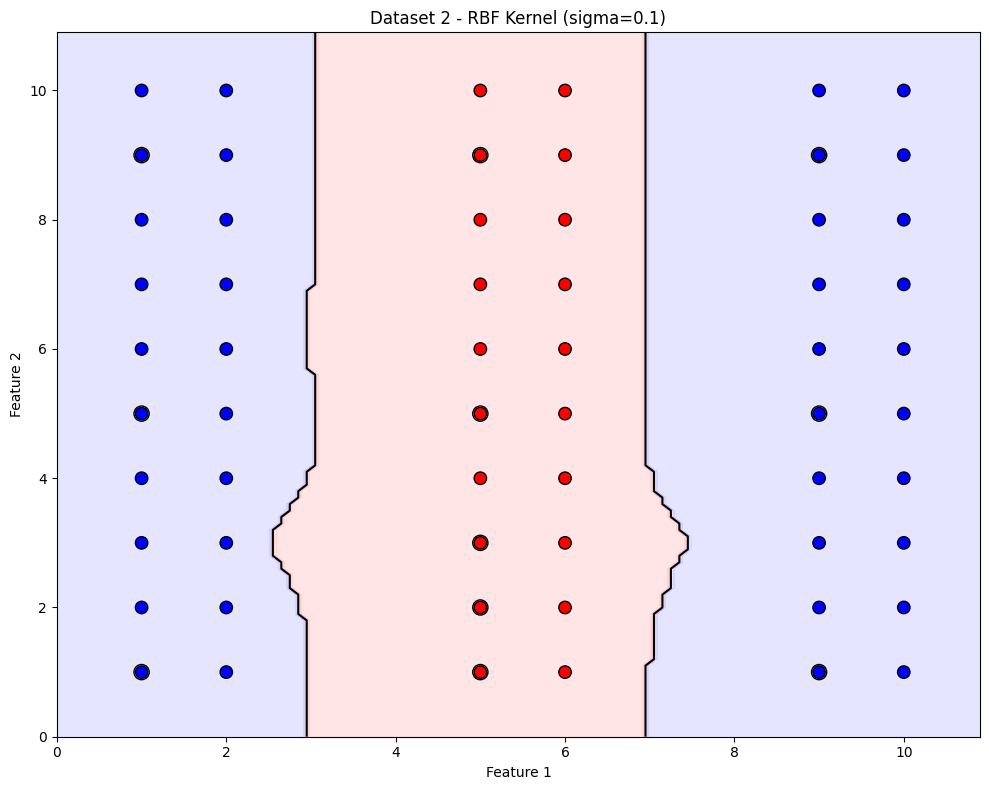

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def quadratic_kernel(x, z, c):
    """
    Quadratic kernel: K(x, z) = (x·z + c)²
    
    Args:
        x: First data point (shape: (n_features,))
        z: Second data point (shape: (n_features,))
        c: Constant term added before squaring
        
    Returns:
        Kernel value
    """
    return (np.dot(x, z) + c)**2

def rbf_kernel(x, z, c):
    """
    RBF kernel: K(x, z) = exp(-||x-z||²/(2*c²))
    
    Args:
        x: First data point (shape: (n_features,))
        z: Second data point (shape: (n_features,))
        c: Width parameter of the RBF kernel (sigma)
        
    Returns:
        Kernel value
    """
    return np.exp(-np.linalg.norm(x - z)**2 / (2 * c**2))

def train(x, y, kernel_function, c=1.0, max_iter=1000):
    """
    Train a kernel perceptron.
    
    Args:
        x: Training data of shape (n_samples, n_features)
        y: Training labels of shape (n_samples,)
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        max_iter: Maximum number of iterations
        
    Returns:
        alpha: Weight vector
        b: Bias term
    """
    n_samples = len(x)
    alpha = np.zeros(n_samples)
    b = 0
    
    # Precompute kernel matrix for efficiency
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel_function(x[i], x[j], c)
    
    # Training loop
    for _ in range(max_iter):
        mistakes = False
        
        for i in range(n_samples):
            # Compute prediction
            f_xi = 0
            for j in range(n_samples):
                f_xi += alpha[j] * y[j] * K[i, j]
            f_xi += b
            
            # Update if misclassified
            if y[i] * f_xi <= 0:
                alpha[i] += 1
                b += y[i]
                mistakes = True
        
        # If no mistakes were made, we're done
        if not mistakes:
            print("Converged!")
            break
    
    # Count support vectors
    support_vectors = np.sum(alpha > 0)
    print(f"Number of support vectors: {support_vectors}")
    
    return alpha, b

def classify(x, y, alpha, b, xi, kernel_function, c=1.0):
    """
    Classify a new data point using the kernel perceptron.
    
    Args:
        x: Training data of shape (n_samples, n_features)
        y: Training labels of shape (n_samples,)
        alpha: Weight vector
        b: Bias term
        xi: New data point to classify
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        
    Returns:
        Predicted label (-1 or 1)
    """
    f_xi = 0
    for i in range(len(x)):
        f_xi += alpha[i] * y[i] * kernel_function(x[i], xi, c)
    f_xi += b
    
    return 1 if f_xi >= 0 else -1

def plot_decision_boundary(x, y, alpha, b, kernel_function, c, title):
    """
    Plot the decision boundary of a kernel perceptron model.
    
    Args:
        x: Training data
        y: Training labels
        alpha: Weight vector
        b: Bias term
        kernel_function: Kernel function to use
        c: Parameter for the kernel function
        title: Plot title
    """
    # Set plot boundaries
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    # Create a mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Predict on the mesh grid
    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            xi = np.array([xx[i, j], yy[i, j]])
            Z[i, j] = classify(x, y, alpha, b, xi, kernel_function, c)
    
    # Plot decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    plt.contour(xx, yy, Z, colors='k', linestyles=['-'], levels=[0])
    
    # Plot data points
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), 
               edgecolors='k', s=80)
    
    # Highlight support vectors
    support_vectors = np.where(alpha > 0)[0]
    plt.scatter(x[support_vectors, 0], x[support_vectors, 1], 
              s=120, linewidth=1, facecolors='none', edgecolors='k')
    
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.tight_layout()
    #plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300)
    plt.show()

def main():
    # Load data
    data1 = np.loadtxt('data1.txt')
    data2 = np.loadtxt('data2.txt')
    
    # Extract features and labels
    x1 = data1[:, :2]
    y1 = data1[:, 2]
    
    x2 = data2[:, :2]
    y2 = data2[:, 2]
    
    # Part (a): Quadratic kernel
    print("\nTraining on dataset 1 with quadratic kernel...")
    alpha1_quad, b1_quad = train(x1, y1, quadratic_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_quad, b1_quad, quadratic_kernel, c=1.0,
                          title="Dataset 1 - Quadratic Kernel")
    
    print("\nTraining on dataset 2 with quadratic kernel...")
    alpha2_quad, b2_quad = train(x2, y2, quadratic_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_quad, b2_quad, quadratic_kernel, c=1.0,
                          title="Dataset 2 - Quadratic Kernel")
    
    # Part (b): RBF kernel with sigma = 1.0
    print("\nTraining on dataset 1 with RBF kernel (sigma=1.0)...")
    alpha1_rbf1, b1_rbf1 = train(x1, y1, rbf_kernel, c=1.0)
    plot_decision_boundary(x1, y1, alpha1_rbf1, b1_rbf1, rbf_kernel, c=1.0,
                          title="Dataset 1 - RBF Kernel (sigma=1.0)")
    
    print("\nTraining on dataset 2 with RBF kernel (sigma=1.0)...")
    alpha2_rbf1, b2_rbf1 = train(x2, y2, rbf_kernel, c=1.0)
    plot_decision_boundary(x2, y2, alpha2_rbf1, b2_rbf1, rbf_kernel, c=1.0,
                          title="Dataset 2 - RBF Kernel (sigma=1.0)")
    
    # Part (b): RBF kernel with sigma = 0.1
    print("\nTraining on dataset 1 with RBF kernel (sigma=0.1)...")
    alpha1_rbf2, b1_rbf2 = train(x1, y1, rbf_kernel, c=0.1)
    plot_decision_boundary(x1, y1, alpha1_rbf2, b1_rbf2, rbf_kernel, c=0.1,
                          title="Dataset 1 - RBF Kernel (sigma=0.1)")
    
    print("\nTraining on dataset 2 with RBF kernel (sigma=0.1)...")
    alpha2_rbf2, b2_rbf2 = train(x2, y2, rbf_kernel, c=0.1)
    plot_decision_boundary(x2, y2, alpha2_rbf2, b2_rbf2, rbf_kernel, c=0.1,
                          title="Dataset 2 - RBF Kernel (sigma=0.1)")

main()

Training on dataset 1 with quadratic kernel...
Converged after 1000 iterations
Number of support vectors: 27
Training on dataset 2 with quadratic kernel...
Converged after 1000 iterations
Number of support vectors: 24
Training on dataset 1 with RBF kernel (sigma=1.0)...
Converged after 3 iterations
Number of support vectors: 4


/tmp/ipykernel_1323514/778770221.py:120: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K[i, j] = self._get_kernel(X[i], X[j])


Training on dataset 2 with RBF kernel (sigma=1.0)...
Converged after 2 iterations
Number of support vectors: 3
Training on dataset 1 with RBF kernel (sigma=0.1)...
Converged after 2 iterations
Number of support vectors: 9
Training on dataset 2 with RBF kernel (sigma=0.1)...
Converged after 2 iterations
Number of support vectors: 9


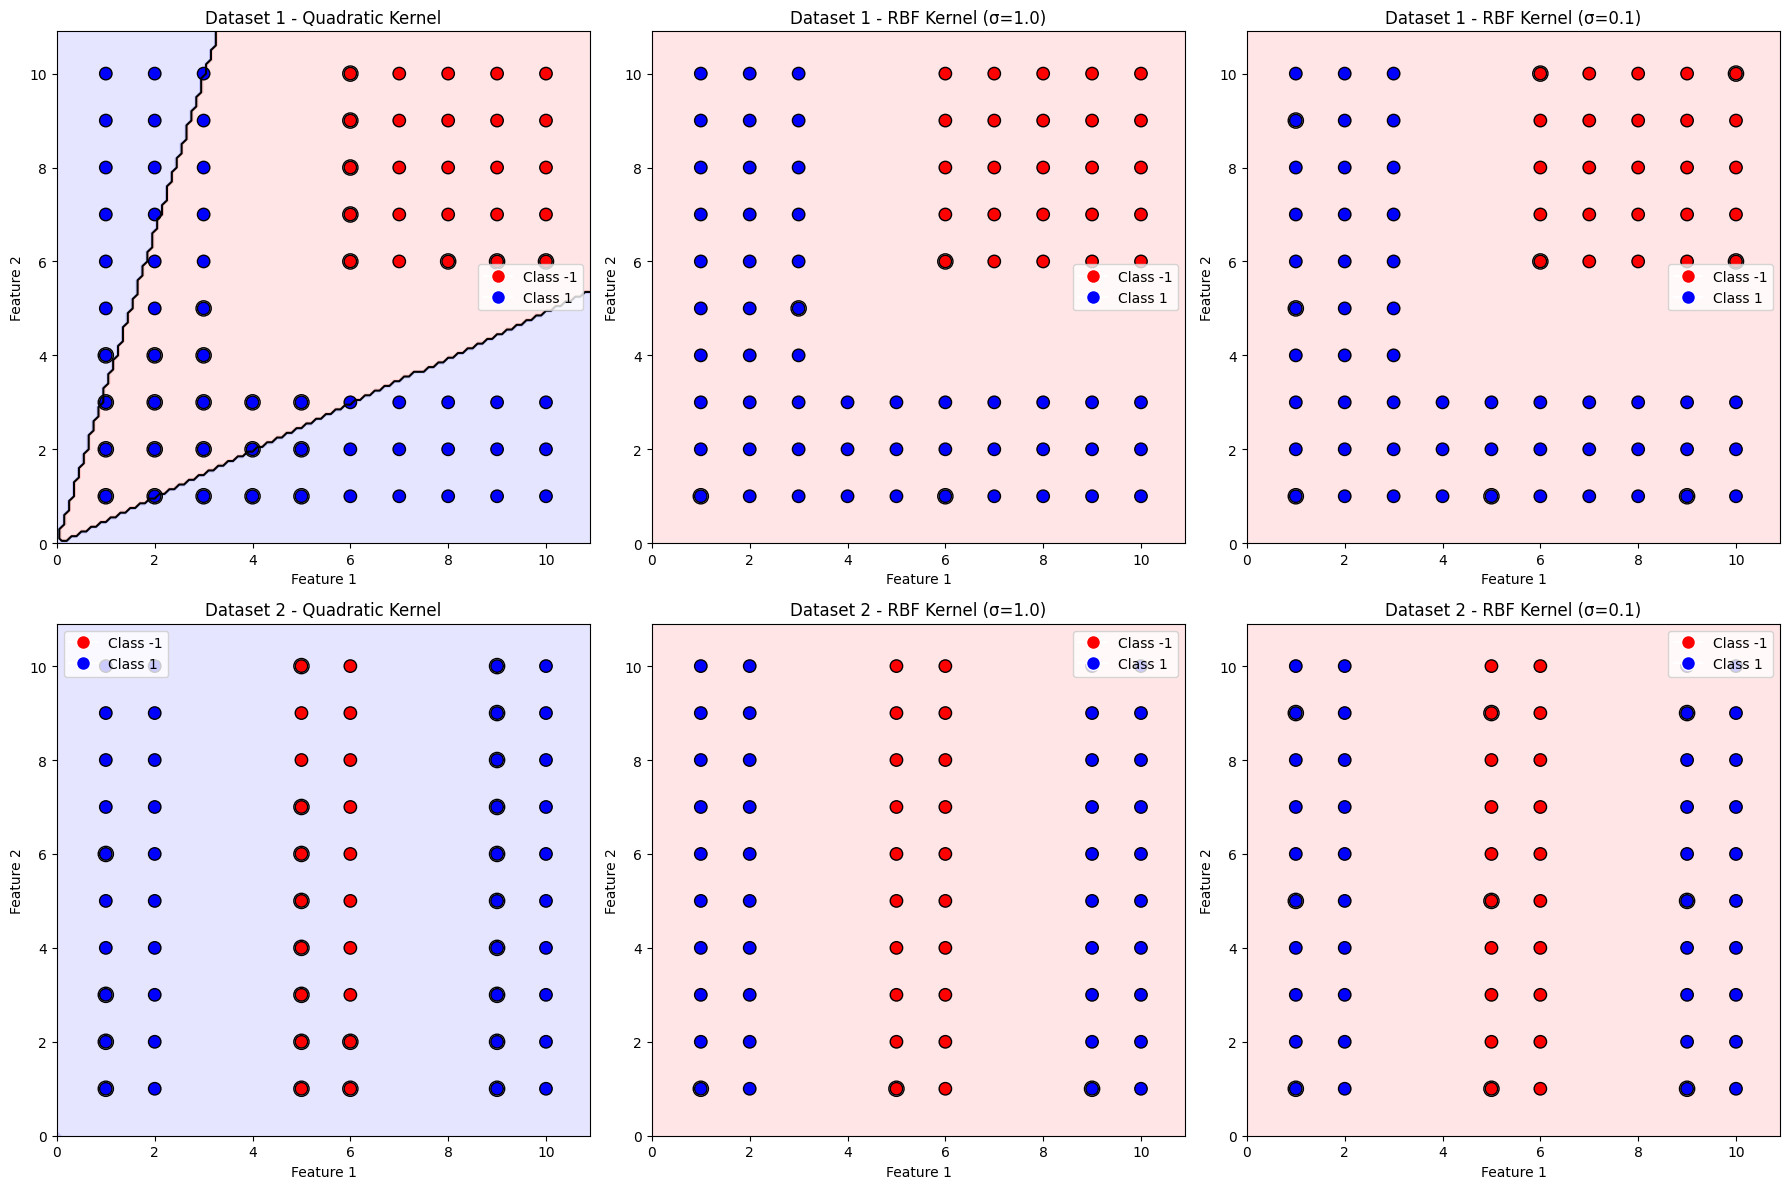

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import time

def quadratic_kernel(x1, x2):
    """
    Quadratic kernel: K(x1, x2) = (x1^T * x2)^2
    
    Args:
        x1: First vector or matrix of shape (n_features,) or (n_samples, n_features)
        x2: Second vector or matrix of shape (n_features,) or (m_samples, n_features)
        
    Returns:
        Kernel value(s)
    """
    return np.dot(x1, x2.T) ** 2

def rbf_kernel(x1, x2, sigma=1.0):
    """
    RBF (Gaussian) kernel: K(x1, x2) = exp(-||x1 - x2||^2 / (2 * sigma^2))
    
    Args:
        x1: First vector or matrix of shape (n_features,) or (n_samples, n_features)
        x2: Second vector or matrix of shape (n_features,) or (m_samples, n_features)
        sigma: Width parameter of the RBF kernel
        
    Returns:
        Kernel value(s)
    """
    # Handle both vector and matrix inputs
    if x1.ndim == 1:
        x1 = x1.reshape(1, -1)
    if x2.ndim == 1:
        x2 = x2.reshape(1, -1)
    
    # Compute squared Euclidean distance
    n_samples_1 = x1.shape[0]
    n_samples_2 = x2.shape[0]
    
    # Expand dimensions to compute pairwise distances
    # ||x1 - x2||^2 = ||x1||^2 + ||x2||^2 - 2*x1^T*x2
    x1_norm = np.sum(x1 ** 2, axis=1).reshape(n_samples_1, 1)
    x2_norm = np.sum(x2 ** 2, axis=1).reshape(1, n_samples_2)
    distances = x1_norm + x2_norm - 2 * np.dot(x1, x2.T)
    
    # Apply RBF formula
    return np.exp(-distances / (2 * sigma ** 2))

class KernelPerceptron:
    """
    Kernel Perceptron classifier for binary classification.
    
    Attributes:
        kernel: Kernel function to use ('quadratic' or 'rbf')
        sigma: Width parameter for RBF kernel
        max_iter: Maximum number of iterations
        alpha: Weights for support vectors
        support_vectors: Training examples that contribute to the decision function
        support_vector_labels: Labels of support vectors
    """
    
    def __init__(self, kernel='quadratic', sigma=1.0, max_iter=1000):
        """
        Initialize the Kernel Perceptron.
        
        Args:
            kernel: Kernel function to use ('quadratic' or 'rbf')
            sigma: Width parameter for RBF kernel
            max_iter: Maximum number of iterations
        """
        self.kernel = kernel
        self.sigma = sigma
        self.max_iter = max_iter
        self.alpha = None
        self.support_vectors = None
        self.support_vector_labels = None
        
    def _get_kernel(self, x1, x2):
        """
        Apply the selected kernel function.
        
        Args:
            x1, x2: Input vectors or matrices
            
        Returns:
            Kernel values
        """
        if self.kernel == 'quadratic':
            return quadratic_kernel(x1, x2)
        elif self.kernel == 'rbf':
            return rbf_kernel(x1, x2, self.sigma)
        else:
            raise ValueError(f"Unsupported kernel: {self.kernel}")
    
    def fit(self, X, y):
        """
        Fit the Kernel Perceptron to the training data.
        
        Args:
            X: Training data of shape (n_samples, n_features)
            y: Target labels of shape (n_samples,)
            
        Returns:
            self: Returns an instance of self
        """
        n_samples, n_features = X.shape
        
        # Initialize alpha coefficients
        self.alpha = np.zeros(n_samples)
        
        # Store training data
        self.support_vectors = X
        self.support_vector_labels = y
        
        # Precompute kernel matrix for efficiency
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self._get_kernel(X[i], X[j])
        
        # Training loop
        converged = False
        n_iter = 0
        
        while not converged and n_iter < self.max_iter:
            converged = True
            n_iter += 1
            
            for i in range(n_samples):
                # Compute prediction
                prediction = np.sign(np.sum(self.alpha * self.support_vector_labels * K[i, :]))
                
                # Update if misclassified
                if prediction * y[i] <= 0:
                    self.alpha[i] += 1
                    converged = False
        
        # Keep only support vectors (examples with non-zero alpha)
        sv_indices = np.where(self.alpha > 0)[0]
        self.alpha = self.alpha[sv_indices]
        self.support_vectors = X[sv_indices]
        self.support_vector_labels = y[sv_indices]
        
        print(f"Converged after {n_iter} iterations")
        print(f"Number of support vectors: {len(self.alpha)}")
        
        return self
    
    def predict(self, X):
        """
        Predict class labels for samples in X.
        
        Args:
            X: Samples of shape (n_samples, n_features)
            
        Returns:
            y_pred: Predicted class labels
        """
        n_samples = X.shape[0]
        y_pred = np.zeros(n_samples)
        
        for i in range(n_samples):
            # Compute kernel values between test point and all support vectors
            K = np.array([self._get_kernel(X[i], sv) for sv in self.support_vectors])
            
            # Compute decision function
            y_pred[i] = np.sign(np.sum(self.alpha * self.support_vector_labels * K))
            
        return y_pred
    
    def decision_function(self, X):
        """
        Compute the decision function for samples in X.
        
        Args:
            X: Samples of shape (n_samples, n_features)
            
        Returns:
            Decision function values
        """
        n_samples = X.shape[0]
        decision_values = np.zeros(n_samples)
        
        for i in range(n_samples):
            # Compute kernel values between test point and all support vectors
            K = np.array([self._get_kernel(X[i], sv) for sv in self.support_vectors])
            
            # Compute decision function
            decision_values[i] = np.sum(self.alpha * self.support_vector_labels * K)
            
        return decision_values

def plot_decision_boundary(model, X, y, title="Decision Boundary", ax=None):
    """
    Plot the decision boundary of a kernel perceptron model.
    
    Args:
        model: Trained KernelPerceptron model
        X: Training data
        y: Training labels
        title: Plot title
        ax: Matplotlib axis (optional)
        
    Returns:
        Matplotlib axis
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Set plot boundaries
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Create a mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Predict on the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and margins
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
    ax.contour(xx, yy, Z, colors='k', linestyles=['-'], levels=[0])
    
    # Plot data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), 
               edgecolors='k', s=80)
    
    # Highlight support vectors
    if hasattr(model, 'support_vectors'):
        ax.scatter(model.support_vectors[:, 0], model.support_vectors[:, 1], 
                  s=120, linewidth=1, facecolors='none', edgecolors='k')
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', 
                                 markersize=10, label='Class -1'),
                      plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', 
                                markersize=10, label='Class 1')]
    ax.legend(handles=legend_elements, loc='best')
    
    return ax

def load_data(filename):
    """
    Load data from a text file.
    
    Args:
        filename: Path to the data file
        
    Returns:
        X: Features
        y: Labels
    """
    data = np.loadtxt(filename)
    X = data[:, :2]
    y = data[:, 2]
    return X, y

def main():
    # Load datasets
    X1, y1 = load_data('data1.txt')
    X2, y2 = load_data('data2.txt')
    
    # Create figure for all plots
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    
    # Dataset 1 with quadratic kernel
    print("Training on dataset 1 with quadratic kernel...")
    model1_quad = KernelPerceptron(kernel='quadratic')
    model1_quad.fit(X1, y1)
    plot_decision_boundary(model1_quad, X1, y1, 
                          title="Dataset 1 - Quadratic Kernel", 
                          ax=axs[0, 0])
    
    # Dataset 2 with quadratic kernel
    print("Training on dataset 2 with quadratic kernel...")
    model2_quad = KernelPerceptron(kernel='quadratic')
    model2_quad.fit(X2, y2)
    plot_decision_boundary(model2_quad, X2, y2, 
                          title="Dataset 2 - Quadratic Kernel", 
                          ax=axs[1, 0])
    
    # Dataset 1 with RBF kernel (sigma=1.0)
    print("Training on dataset 1 with RBF kernel (sigma=1.0)...")
    model1_rbf1 = KernelPerceptron(kernel='rbf', sigma=1.0)
    model1_rbf1.fit(X1, y1)
    plot_decision_boundary(model1_rbf1, X1, y1, 
                          title="Dataset 1 - RBF Kernel (σ=1.0)", 
                          ax=axs[0, 1])
    
    # Dataset 2 with RBF kernel (sigma=1.0)
    print("Training on dataset 2 with RBF kernel (sigma=1.0)...")
    model2_rbf1 = KernelPerceptron(kernel='rbf', sigma=1.0)
    model2_rbf1.fit(X2, y2)
    plot_decision_boundary(model2_rbf1, X2, y2, 
                          title="Dataset 2 - RBF Kernel (σ=1.0)", 
                          ax=axs[1, 1])
    
    # Dataset 1 with RBF kernel (sigma=0.1)
    print("Training on dataset 1 with RBF kernel (sigma=0.1)...")
    model1_rbf2 = KernelPerceptron(kernel='rbf', sigma=0.1)
    model1_rbf2.fit(X1, y1)
    plot_decision_boundary(model1_rbf2, X1, y1, 
                          title="Dataset 1 - RBF Kernel (σ=0.1)", 
                          ax=axs[0, 2])
    
    # Dataset 2 with RBF kernel (sigma=0.1)
    print("Training on dataset 2 with RBF kernel (sigma=0.1)...")
    model2_rbf2 = KernelPerceptron(kernel='rbf', sigma=0.1)
    model2_rbf2.fit(X2, y2)
    plot_decision_boundary(model2_rbf2, X2, y2, 
                          title="Dataset 2 - RBF Kernel (σ=0.1)", 
                          ax=axs[1, 2])
    
    plt.tight_layout()
    #plt.savefig('kernel_perceptron_results.png', dpi=300)
    plt.show()

main()
